In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from scipy.stats import pearsonr
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse
from pylab import rcParams
pd.set_option('display.max_columns',None)
import warnings
warnings.filterwarnings('ignore')

# data

In [2]:
data_owid = pd.read_csv("./dataset/owid-energy-data.csv")

In [3]:
data_owid

country  year iso_code  population           gdp  \
0      ASEAN (Ember)  2000      NaN         NaN           NaN   
1      ASEAN (Ember)  2001      NaN         NaN           NaN   
2      ASEAN (Ember)  2002      NaN         NaN           NaN   
3      ASEAN (Ember)  2003      NaN         NaN           NaN   
4      ASEAN (Ember)  2004      NaN         NaN           NaN   
...              ...   ...      ...         ...           ...   
21807       Zimbabwe  2019      ZWE  15354606.0  2.514642e+10   
21808       Zimbabwe  2020      ZWE  15669663.0  2.317871e+10   
21809       Zimbabwe  2021      ZWE  15993525.0  2.514009e+10   
21810       Zimbabwe  2022      ZWE  16320539.0  2.590159e+10   
21811       Zimbabwe  2023      ZWE  16665407.0           NaN   

       biofuel_cons_change_pct  biofuel_cons_change_twh  \
0                          NaN                      NaN   
1                          NaN                      NaN   
2                          NaN                      NaN   
3                          NaN                      NaN   
4                          NaN                      NaN   
...                        ...                      ...   
21807                      NaN                      NaN   
21808                      NaN                      NaN   
21809                      NaN                      NaN   
21810                      NaN                      NaN   
21811                      NaN                      NaN   

       biofuel_cons_per_capita  biofuel_consumption  biofuel_elec_per_capita  \
0                          NaN                  NaN                      NaN   
1                          NaN                  NaN                      NaN   
2                          NaN                  NaN                      NaN   
3                          NaN                  NaN                      NaN   
4                          NaN                  NaN                      NaN   
...                        ...                  ...                      ...   
21807                      NaN                  NaN                   12.374   
21808                      NaN                  NaN                    6.382   
21809                      NaN                  NaN                    0.000   
21810                      NaN                  NaN                    6.127   
21811                      NaN                  NaN                      NaN   

       biofuel_electricity  biofuel_share_elec  biofuel_share_energy  \
0                     5.87               1.550                   NaN   
1                     6.46               1.596                   NaN   
2                     6.62               1.528                   NaN   
3                     7.45               1.626                   NaN   
4                     8.40               1.692                   NaN   
...                    ...                 ...                   ...   
21807                 0.19               2.238                   NaN   
21808                 0.10               1.490                   NaN   
21809                 0.00               0.000                   NaN   
21810                 0.10               1.120                   NaN   
21811                  NaN                 NaN                   NaN   

       carbon_intensity_elec  coal_cons_change_pct  coal_cons_change_twh  \
0                    569.557                   NaN                   NaN   
1                    567.642                   NaN                   NaN   
2                    570.212                   NaN                   NaN   
3                    574.699                   NaN                   NaN   
4                    581.420                   NaN                   NaN   
...                      ...                   ...                   ...   
21807                428.740                   NaN                   NaN   
21808                371.088                   NaN                   NaN   
21809        

In [4]:
cpi = pd.read_csv('./dataset/consumer-price-index.csv')

In [5]:
cpi

Entity Code  Year  Consumer price index (2010 = 100)
0   Italy  ITA  1960                           4.147836
1   Italy  ITA  1961                           4.232895
2   Italy  ITA  1962                           4.431467
3   Italy  ITA  1963                           4.761820
4   Italy  ITA  1964                           5.043354
..    ...  ...   ...                                ...
59  Italy  ITA  2019                         110.623600
60  Italy  ITA  2020                         110.471260
61  Italy  ITA  2021                         112.541250
62  Italy  ITA  2022                         121.771090
63  Italy  ITA  2023                         128.617300

[64 rows x 4 columns]

In [6]:
cpi = cpi[['Year','Consumer price index (2010 = 100)']].reset_index(drop=True)

In [7]:
cpi['Year'] = pd.to_datetime(cpi['Year'],format='%Y')

In [8]:
cpi = cpi.rename(columns={'Consumer price index (2010 = 100)':'cpi','Year':'year'})

In [9]:
cpi = cpi.set_index('year').dropna()

In [10]:
cpi

cpi
year                  
1960-01-01    4.147836
1961-01-01    4.232895
1962-01-01    4.431467
1963-01-01    4.761820
1964-01-01    5.043354
...                ...
2019-01-01  110.623600
2020-01-01  110.471260
2021-01-01  112.541250
2022-01-01  121.771090
2023-01-01  128.617300

[64 rows x 1 columns]

In [11]:
co2 = pd.read_csv('./dataset/annual-co2-emissions-per-country.csv')

In [12]:
co2

Entity Code  Year  Annual CO₂ emissions
0    Italy  ITA  1860               29312.0
1    Italy  ITA  1861              670512.0
2    Italy  ITA  1862             1227440.0
3    Italy  ITA  1863             1069888.0
4    Italy  ITA  1864             1604832.0
..     ...  ...   ...                   ...
159  Italy  ITA  2019           339633540.0
160  Italy  ITA  2020           302602430.0
161  Italy  ITA  2021           335977820.0
162  Italy  ITA  2022           340672300.0
163  Italy  ITA  2023           313460640.0

[164 rows x 4 columns]

In [13]:
co2 = co2[['Year','Annual CO₂ emissions']].reset_index(drop=True)

In [14]:
co2['Year'] = pd.to_datetime(co2['Year'],format='%Y')

In [15]:
co2 = co2.rename(columns={'Annual CO₂ emissions':'co2','Year':'year'})

In [16]:
co2 = co2.set_index('year').dropna()

In [17]:
co2

co2
year                   
1860-01-01      29312.0
1861-01-01     670512.0
1862-01-01    1227440.0
1863-01-01    1069888.0
1864-01-01    1604832.0
...                 ...
2019-01-01  339633540.0
2020-01-01  302602430.0
2021-01-01  335977820.0
2022-01-01  340672300.0
2023-01-01  313460640.0

[164 rows x 1 columns]

In [18]:
density = pd.read_csv('./dataset/population-density.csv')

In [19]:
density

Entity Code  Year  Population density
0    Italy  ITA  1400           27.066790
1    Italy  ITA  1500           30.448635
2    Italy  ITA  1600           44.898500
3    Italy  ITA  1700           45.602116
4    Italy  ITA  1710           47.004980
..     ...  ...   ...                 ...
309  Italy  ITA  2096          122.844600
310  Italy  ITA  2097          122.036360
311  Italy  ITA  2098          121.236260
312  Italy  ITA  2099          120.438385
313  Italy  ITA  2100          119.630510

[314 rows x 4 columns]

In [20]:
density = density[['Year','Population density']].loc[density['Year'] >= 1931].reset_index(drop=True)

In [21]:
density['Year'] = pd.to_datetime(density['Year'],format='%Y')

In [22]:
density = density.rename(columns={'Population density':'density','Year':'year'})

In [23]:
density = density.set_index('year').dropna()

In [24]:
density

density
year                  
1931-01-01  136.959120
1932-01-01  138.116010
1933-01-01  139.273390
1934-01-01  140.440480
1935-01-01  141.617320
...                ...
2096-01-01  122.844600
2097-01-01  122.036360
2098-01-01  121.236260
2099-01-01  120.438385
2100-01-01  119.630510

[170 rows x 1 columns]

In [25]:
precipitation = pd.read_csv('./dataset/average-precipitation-per-year.csv')

In [26]:
precipitation

Entity Code  Year  Annual precipitation
0   Italy  ITA  1931              980.4897
1   Italy  ITA  1932              876.2479
2   Italy  ITA  1933              986.2547
3   Italy  ITA  1934              874.7829
4   Italy  ITA  1935              987.7974
..    ...  ...   ...                   ...
89  Italy  ITA  2020              981.3541
90  Italy  ITA  2021              990.3465
91  Italy  ITA  2022              818.1664
92  Italy  ITA  2023             1025.3726
93  Italy  ITA  2024             1148.2227

[94 rows x 4 columns]

In [27]:
precipitation = precipitation[['Year','Annual precipitation']].reset_index(drop=True)

In [28]:
precipitation['Year'] = pd.to_datetime(precipitation['Year'],format='%Y')

In [29]:
precipitation = precipitation.rename(columns={'Annual precipitation':'precipitation','Year':'year'})

In [30]:
precipitation = precipitation.set_index('year').dropna()

In [31]:
precipitation

precipitation
year                     
1931-01-01       980.4897
1932-01-01       876.2479
1933-01-01       986.2547
1934-01-01       874.7829
1935-01-01       987.7974
...                   ...
2020-01-01       981.3541
2021-01-01       990.3465
2022-01-01       818.1664
2023-01-01      1025.3726
2024-01-01      1148.2227

[94 rows x 1 columns]

In [32]:
temperature = pd.read_csv('./dataset/annual-temperature-anomalies.csv')

In [33]:
temperature

Entity Code  Year  Temperature anomaly
0   Italy  ITA  1931            -2.255135
1   Italy  ITA  1932            -2.025461
2   Italy  ITA  1933            -2.305498
3   Italy  ITA  1934            -0.975453
4   Italy  ITA  1935            -1.751255
..    ...  ...   ...                  ...
89  Italy  ITA  2020             0.610705
90  Italy  ITA  2021             0.337167
91  Italy  ITA  2022             1.275581
92  Italy  ITA  2023             1.230895
93  Italy  ITA  2024             1.333141

[94 rows x 4 columns]

In [34]:
temperature = temperature[['Year','Temperature anomaly']].reset_index(drop=True)

In [35]:
temperature['Year'] = pd.to_datetime(temperature['Year'],format='%Y')

In [36]:
temperature = temperature.rename(columns={'Temperature anomaly':'temperature_anomaly','Year':'year'})

In [37]:
temperature = temperature.set_index('year').dropna()

In [38]:
temperature

temperature_anomaly
year                           
1931-01-01            -2.255135
1932-01-01            -2.025461
1933-01-01            -2.305498
1934-01-01            -0.975453
1935-01-01            -1.751255
...                         ...
2020-01-01             0.610705
2021-01-01             0.337167
2022-01-01             1.275581
2023-01-01             1.230895
2024-01-01             1.333141

[94 rows x 1 columns]

## historical data for EDA

In [39]:
historical_data = data_owid.loc[(data_owid['year'] > 1930) & (data_owid['year'] < 2015) & (data_owid['country'] == 'Italy')]

In [40]:
historical_data

country  year iso_code  population           gdp  \
9980    Italy  1931      ITA  40501139.0  1.866570e+11   
9981    Italy  1932      ITA  40843255.0  1.906655e+11   
9982    Italy  1933      ITA  41185511.0  1.884730e+11   
9983    Italy  1934      ITA  41530635.0  1.879873e+11   
9984    Italy  1935      ITA  41878651.0  1.981434e+11   
...       ...   ...      ...         ...           ...   
10059   Italy  2010      ITA  59822452.0  2.080546e+12   
10060   Italy  2011      ITA  60025952.0  2.110883e+12   
10061   Italy  2012      ITA  60190152.0  2.047960e+12   
10062   Italy  2013      ITA  60312600.0  2.010255e+12   
10063   Italy  2014      ITA  60322792.0  2.010164e+12   

       biofuel_cons_change_pct  biofuel_cons_change_twh  \
9980                       NaN                      NaN   
9981                       NaN                      NaN   
9982                       NaN                      NaN   
9983                       NaN                      NaN   
9984                       NaN                      NaN   
...                        ...                      ...   
10059                   23.119                    2.979   
10060                   -1.207                   -0.192   
10061                   11.624                    1.822   
10062                  -16.044                   -2.807   
10063                  -14.578                   -2.141   

       biofuel_cons_per_capita  biofuel_consumption  biofuel_elec_per_capita  \
9980                       NaN                  NaN                      NaN   
9981                       NaN                  NaN                      NaN   
9982                       NaN                  NaN                      NaN   
9983                       NaN                  NaN                      NaN   
9984                       NaN                  NaN                      NaN   
...                        ...                  ...                      ...   
10059                  265.178               15.864                  157.800   
10060                  261.088               15.672                  180.422   
10061                  290.641               17.494                  207.509   
10062                  243.516               14.687                  283.191   
10063                  207.981               12.546                  310.330   

       biofuel_electricity  biofuel_share_elec  biofuel_share_energy  \
9980                   NaN                 NaN                   NaN   
9981                   NaN                 NaN                   NaN   
9982                   NaN                 NaN                   NaN   
9983                   NaN                 NaN                   NaN   
9984                   NaN                 NaN                   NaN   
...                    ...                 ...                   ...   
10059                 9.44               3.182                 0.779   
10060                10.83               3.630                 0.784   
10061                12.49               4.230                 0.900   
10062                17.08               5.972                 0.790   
10063                18.72               6.770                 0.712   

       carbon_intensity_elec  coal_cons_change_pct  coal_cons_change_twh  \
9980                     NaN                   NaN                   NaN   
9981                     NaN                   NaN                   NaN   
9982                     NaN                   NaN                   NaN   
9983                     NaN                   NaN                   NaN   
9984                     NaN                   NaN                   NaN   
...                      ...                   ...                   ...   
10059                446.415                10.571                15.204   
10060                445.521                12.100                19.242   
10061                438.103                 2.504                 4.463   
10062         

In [41]:
data = pd.read_csv("./dataset/energy.csv") # produzione lorda e consumo di energia elettrica in Italia - Anni 1883-2014 (milioni di kWh)

In [42]:
data

year tot_production tot_consumption agricultural industry transports  \
0   1931         10,470           8,335          103    6,213        803   
1   1932         10,590           8,420          103    6,223        845   
2   1933         11,650           9,293          114    6,984        860   
3   1934         12,600          10,159          110    7,684        879   
4   1935         13,800          11,168          138    8,583      1,003   
..   ...            ...             ...          ...      ...        ...   
79  2010        302,062         309,885        5,610  138,439     10,666   
80  2011        302,570         313,792        5,907  140,040     10,720   
81  2012        299,275         307,220        5,923  130,801     10,759   
82  2013        289,803         297,288        5,677  124,871     10,774   
83  2014        279,829         291,084        5,372  122,505     10,462   

   public_lighting services domestic_uses  
0              209    1,007             0  
1              225    1,024             0  
2              243    1,092             0  
3              258    1,228             0  
4              267    1,177             0  
..             ...      ...           ...  
79           6,366   79,253        69,551  
80           6,202   80,783        70,140  
81           6,261   84,019        69,457  
82           5,977   83,005        66,983  
83           5,885   82,604        64,255  

[84 rows x 9 columns]

In [43]:
historical_data = historical_data.reset_index(drop=True)

In [44]:
data = data.reset_index(drop=True)

In [45]:
data['population'] = historical_data['population']

In [46]:
data['gdp'] = historical_data['gdp']

In [47]:
data.tail()

year tot_production tot_consumption agricultural industry transports  \
79  2010        302,062         309,885        5,610  138,439     10,666   
80  2011        302,570         313,792        5,907  140,040     10,720   
81  2012        299,275         307,220        5,923  130,801     10,759   
82  2013        289,803         297,288        5,677  124,871     10,774   
83  2014        279,829         291,084        5,372  122,505     10,462   

   public_lighting services domestic_uses  population           gdp  
79           6,366   79,253        69,551  59822452.0  2.080546e+12  
80           6,202   80,783        70,140  60025952.0  2.110883e+12  
81           6,261   84,019        69,457  60190152.0  2.047960e+12  
82           5,977   83,005        66,983  60312600.0  2.010255e+12  
83           5,885   82,604        64,255  60322792.0  2.010164e+12

In [48]:
for col in data.columns:
    if data[col].dtype == 'O':  
        data[col] = data[col].str.replace(',', '', regex=False)
        data[col] = pd.to_numeric(data[col], errors='coerce')

In [49]:
data['year'] = pd.to_datetime(data['year'],format='%Y')

In [50]:
data.set_index('year',inplace=True)

In [51]:
data = data.merge(co2,left_index=True,right_index=True,how='left')

In [52]:
data = data.merge(density,left_index=True,right_index=True,how='left')

In [53]:
data = data.merge(precipitation,left_index=True,right_index=True,how='left')

In [54]:
data = data.merge(temperature,left_index=True,right_index=True,how='left')

In [55]:
data

tot_production  tot_consumption  agricultural  industry  \
year                                                                  
1931-01-01           10470             8335           103      6213   
1932-01-01           10590             8420           103      6223   
1933-01-01           11650             9293           114      6984   
1934-01-01           12600            10159           110      7684   
1935-01-01           13800            11168           138      8583   
...                    ...              ...           ...       ...   
2010-01-01          302062           309885          5610    138439   
2011-01-01          302570           313792          5907    140040   
2012-01-01          299275           307220          5923    130801   
2013-01-01          289803           297288          5677    124871   
2014-01-01          279829           291084          5372    122505   

            transports  public_lighting  services  domestic_uses  population  \
year                                                                           
1931-01-01         803              209      1007              0  40501139.0   
1932-01-01         845              225      1024              0  40843255.0   
1933-01-01         860              243      1092              0  41185511.0   
1934-01-01         879              258      1228              0  41530635.0   
1935-01-01        1003              267      1177              0  41878651.0   
...                ...              ...       ...            ...         ...   
2010-01-01       10666             6366     79253          69551  59822452.0   
2011-01-01       10720             6202     80783          70140  60025952.0   
2012-01-01       10759             6261     84019          69457  60190152.0   
2013-01-01       10774             5977     83005          66983  60312600.0   
2014-01-01       10462             5885     82604          64255  60322792.0   

                     gdp          co2    density  precipitation  \
year                                                              
1931-01-01  1.866570e+11   34172700.0  136.95912      980.48970   
1932-01-01  1.906655e+11   28064604.0  138.11601      876.24790   
1933-01-01  1.884730e+11   30473790.0  139.27339      986.25470   
1934-01-01  1.879873e+11   39660990.0  140.44048      874.78290   
1935-01-01  1.981434e+11   45376240.0  141.61732      987.79740   
...                  ...          ...        ...            ...   
2010-01-01  2.080546e+12  435710340.0  203.45181     1322.84860   
2011-01-01  2.110883e+12  423894300.0  204.14055      878.00850   
2012-01-01  2.047960e+12  403441340.0  204.69395     1010.26935   
2013-01-01  2.010255e+12  369474700.0  205.10768     1195.07190   
2014-01-01  2.010164e+12  349400320.0  205.14250     1240.29090   

            temperature_anomaly  
year                             
1931-01-01            -2.255135  
1932-01-01            -2.025461  
1933-01-01            -2.305498  
1934-01-01            -0.975453  
1935-01-01            -1.751255  
...                         ...  
2010-01-01            -0.527131  
2011-01-01             0.283001  
2012-01-01             0.307669  
2013-01-01            -0.028810  
2014-01-01             0.622167  

[84 rows x 14 columns]

In [56]:
data

tot_production  tot_consumption  agricultural  industry  \
year                                                                  
1931-01-01           10470             8335           103      6213   
1932-01-01           10590             8420           103      6223   
1933-01-01           11650             9293           114      6984   
1934-01-01           12600            10159           110      7684   
1935-01-01           13800            11168           138      8583   
...                    ...              ...           ...       ...   
2010-01-01          302062           309885          5610    138439   
2011-01-01          302570           313792          5907    140040   
2012-01-01          299275           307220          5923    130801   
2013-01-01          289803           297288          5677    124871   
2014-01-01          279829           291084          5372    122505   

            transports  public_lighting  services  domestic_uses  population  \
year                                                                           
1931-01-01         803              209      1007              0  40501139.0   
1932-01-01         845              225      1024              0  40843255.0   
1933-01-01         860              243      1092              0  41185511.0   
1934-01-01         879              258      1228              0  41530635.0   
1935-01-01        1003              267      1177              0  41878651.0   
...                ...              ...       ...            ...         ...   
2010-01-01       10666             6366     79253          69551  59822452.0   
2011-01-01       10720             6202     80783          70140  60025952.0   
2012-01-01       10759             6261     84019          69457  60190152.0   
2013-01-01       10774             5977     83005          66983  60312600.0   
2014-01-01       10462             5885     82604          64255  60322792.0   

                     gdp          co2    density  precipitation  \
year                                                              
1931-01-01  1.866570e+11   34172700.0  136.95912      980.48970   
1932-01-01  1.906655e+11   28064604.0  138.11601      876.24790   
1933-01-01  1.884730e+11   30473790.0  139.27339      986.25470   
1934-01-01  1.879873e+11   39660990.0  140.44048      874.78290   
1935-01-01  1.981434e+11   45376240.0  141.61732      987.79740   
...                  ...          ...        ...            ...   
2010-01-01  2.080546e+12  435710340.0  203.45181     1322.84860   
2011-01-01  2.110883e+12  423894300.0  204.14055      878.00850   
2012-01-01  2.047960e+12  403441340.0  204.69395     1010.26935   
2013-01-01  2.010255e+12  369474700.0  205.10768     1195.07190   
2014-01-01  2.010164e+12  349400320.0  205.14250     1240.29090   

            temperature_anomaly  
year                             
1931-01-01            -2.255135  
1932-01-01            -2.025461  
1933-01-01            -2.305498  
1934-01-01            -0.975453  
1935-01-01            -1.751255  
...                         ...  
2010-01-01            -0.527131  
2011-01-01             0.283001  
2012-01-01             0.307669  
2013-01-01            -0.028810  
2014-01-01             0.622167  

[84 rows x 14 columns]

## data normalization

In [57]:
data_normalized = data.copy()

In [58]:
avgs = data_normalized.mean()

In [59]:
devs = data_normalized.std()

In [60]:
for col in data_normalized.columns:
    data_normalized[col] = (data_normalized[col] - avgs.loc[col]) / devs.loc[col]

<Axes: xlabel='year'>

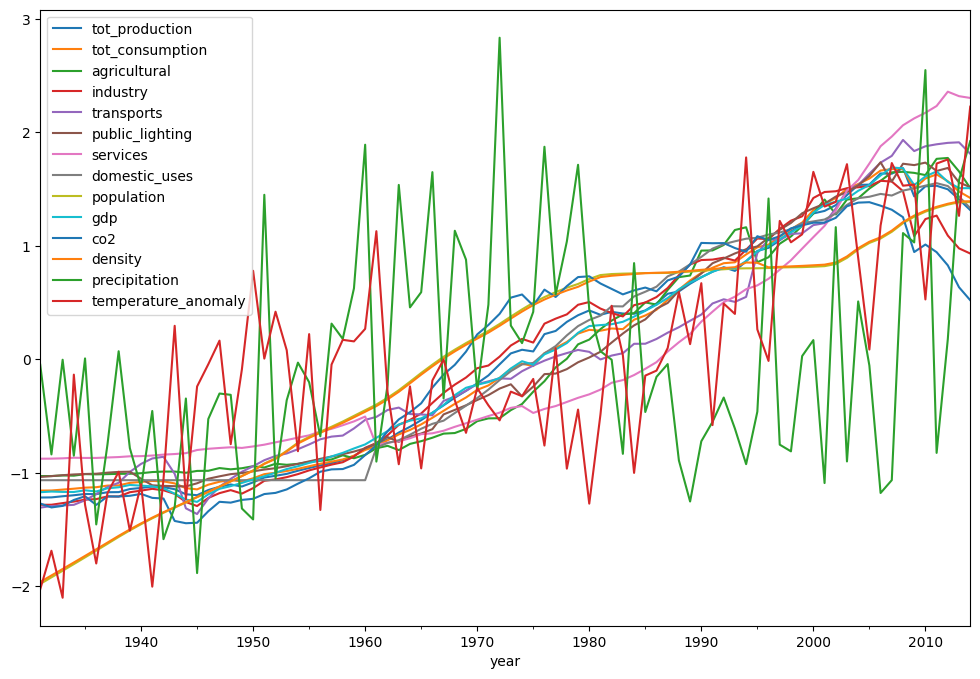

In [61]:
data_normalized.plot(figsize=(12,8))

<Axes: xlabel='year'>

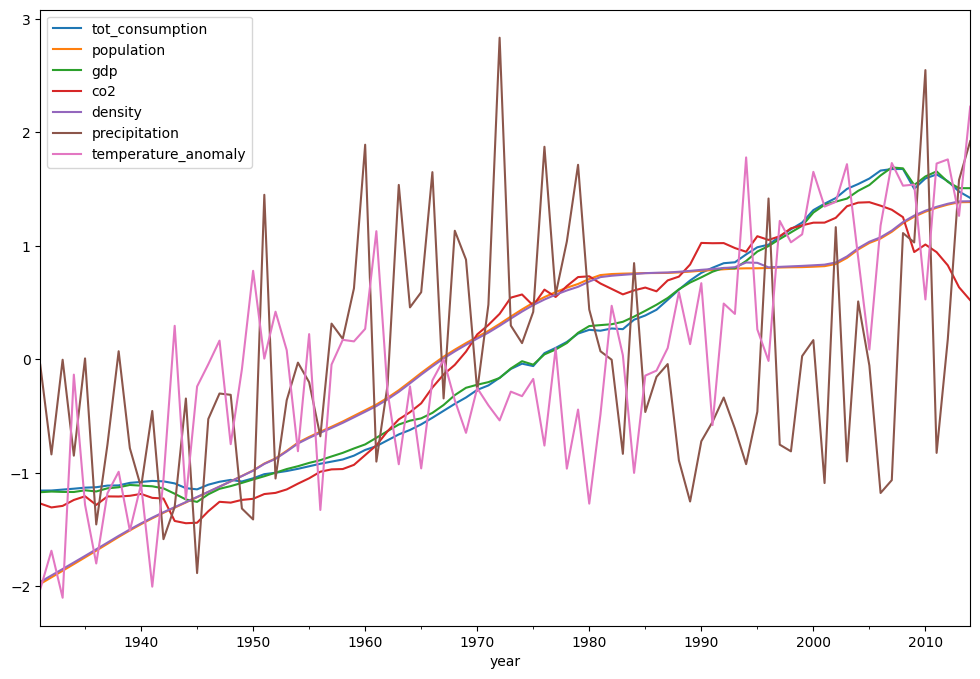

In [62]:
data_normalized[['tot_consumption','population','gdp','co2','density','precipitation','temperature_anomaly']].plot(figsize=(12,8))

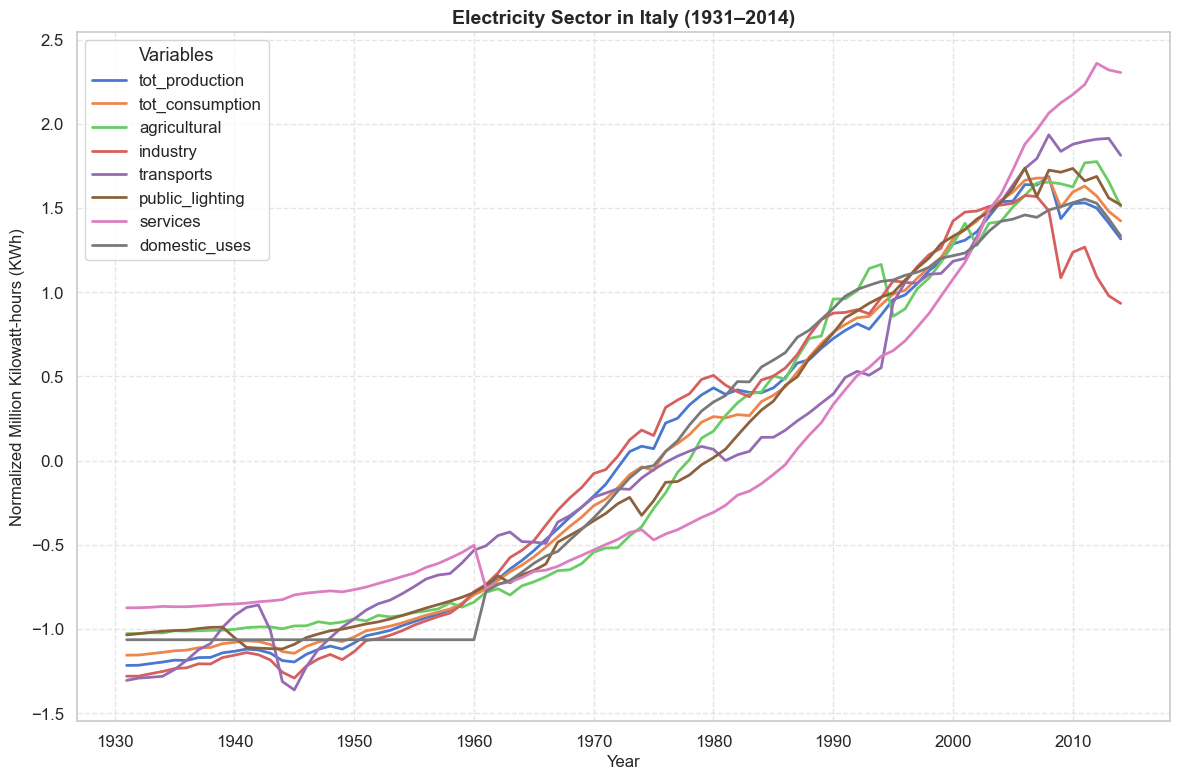

In [63]:
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.figure(figsize=(12,8))

for column in ['tot_production', 'tot_consumption', 'agricultural', 'industry',
       'transports', 'public_lighting', 'services', 'domestic_uses']:
    plt.plot(data_normalized.index, data_normalized[column], label=column, linewidth=2)

plt.title('Electricity Sector in Italy (1931–2014)', fontsize=14, weight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Normalized Million Kilowatt-hours (KWh)', fontsize=12)
plt.legend(loc='upper left', title="Variables")

plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

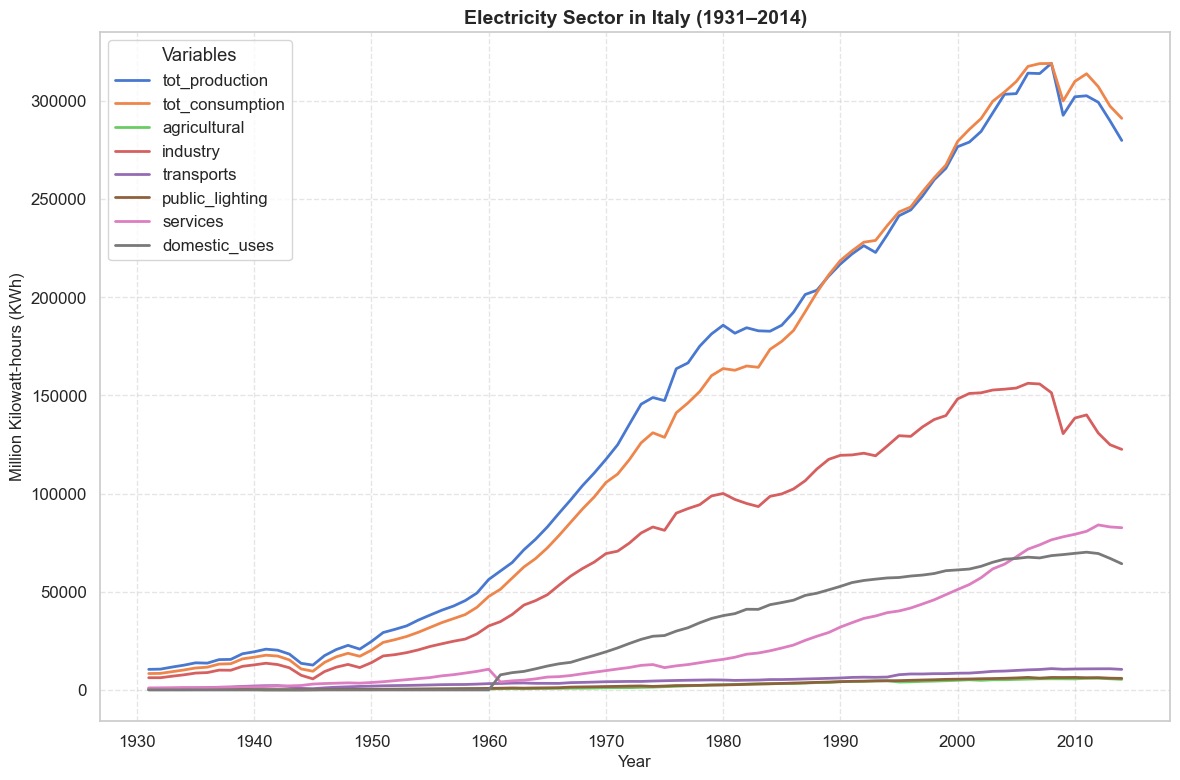

In [64]:
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.figure(figsize=(12,8))

for column in ['tot_production', 'tot_consumption', 'agricultural', 'industry',
       'transports', 'public_lighting', 'services', 'domestic_uses']:
    plt.plot(data.index, data[column], label=column, linewidth=2)

plt.title('Electricity Sector in Italy (1931–2014)', fontsize=14, weight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Million Kilowatt-hours (KWh)', fontsize=12)
plt.legend(loc='upper left', title="Variables")

plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

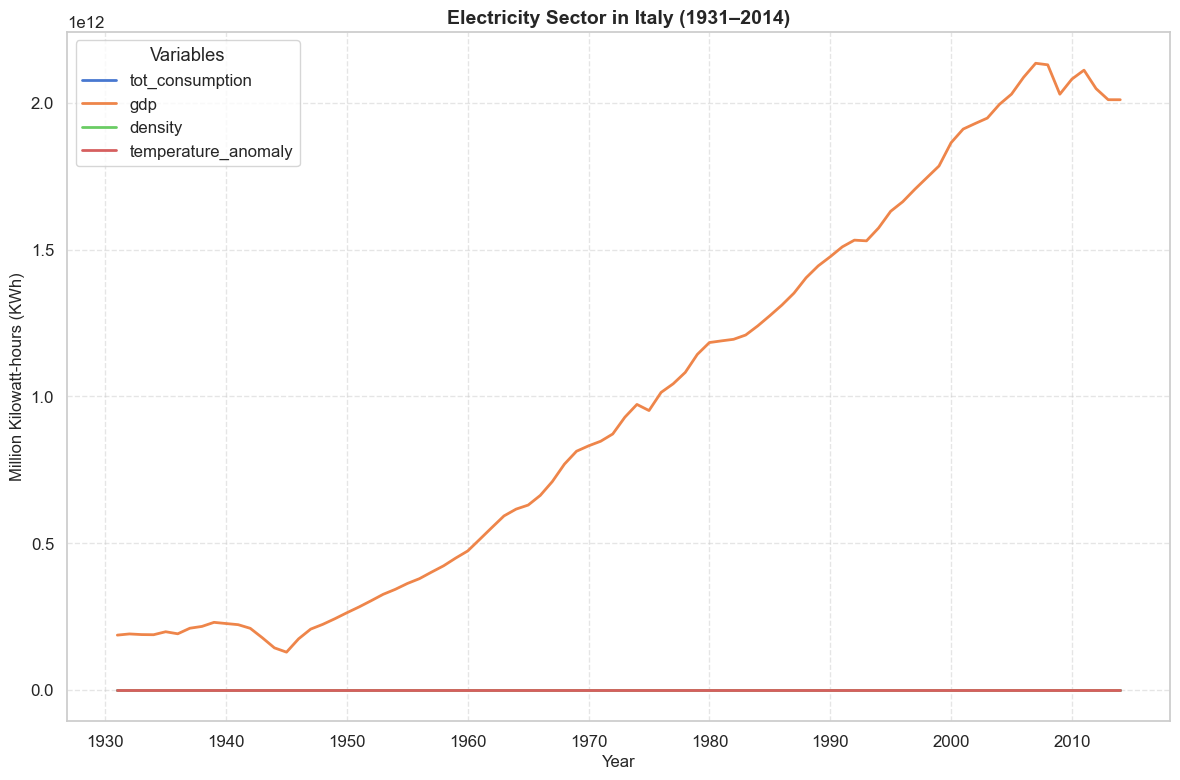

In [65]:
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.figure(figsize=(12,8))

for column in ['tot_consumption','gdp','density','temperature_anomaly']:
    plt.plot(data.index, data[column], label=column, linewidth=2)

plt.title('Electricity Sector in Italy (1931–2014)', fontsize=14, weight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Million Kilowatt-hours (KWh)', fontsize=12)
plt.legend(loc='upper left', title="Variables")

plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

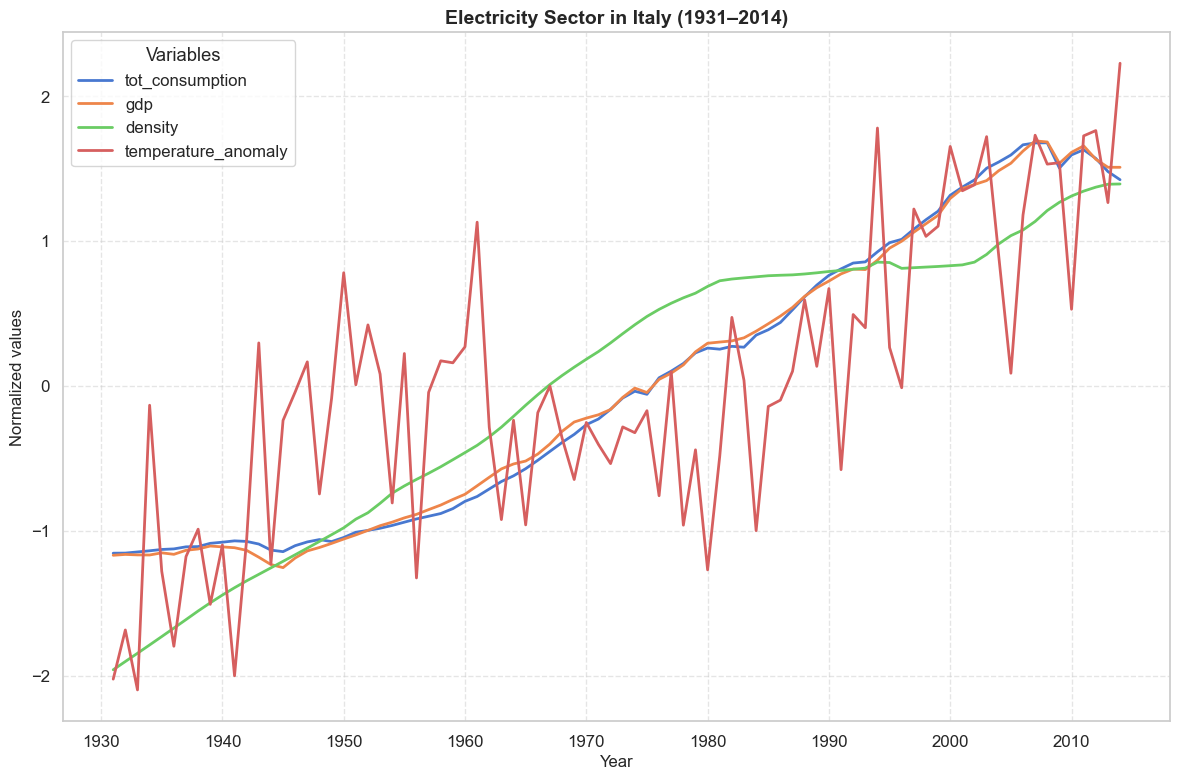

In [66]:
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.figure(figsize=(12,8))

for column in ['tot_consumption','gdp','density','temperature_anomaly']:
    plt.plot(data_normalized.index, data_normalized[column], label=column, linewidth=2)

plt.title('Electricity Sector in Italy (1931–2014)', fontsize=14, weight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Normalized values', fontsize=12)
plt.legend(loc='upper left', title="Variables")

plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

<Axes: xlabel='year'>

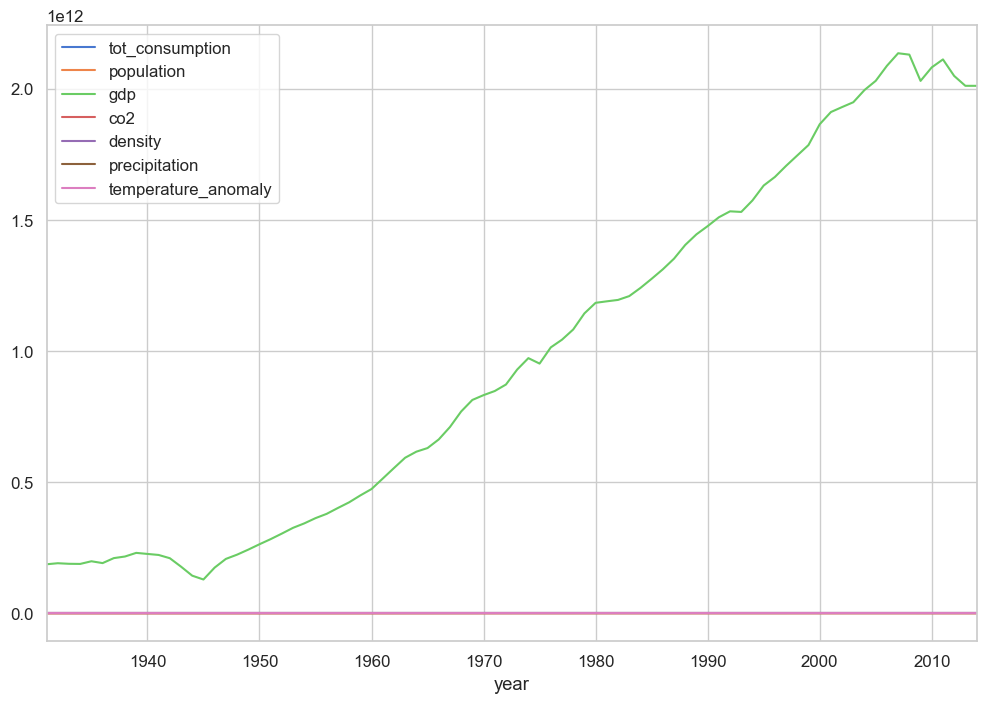

In [67]:
data[['tot_consumption','population','gdp','co2','density','precipitation','temperature_anomaly']].plot(figsize=(12,8))

In [68]:
prod_cycle,prod_trend = hpfilter(data['tot_production'])

<Axes: xlabel='year'>

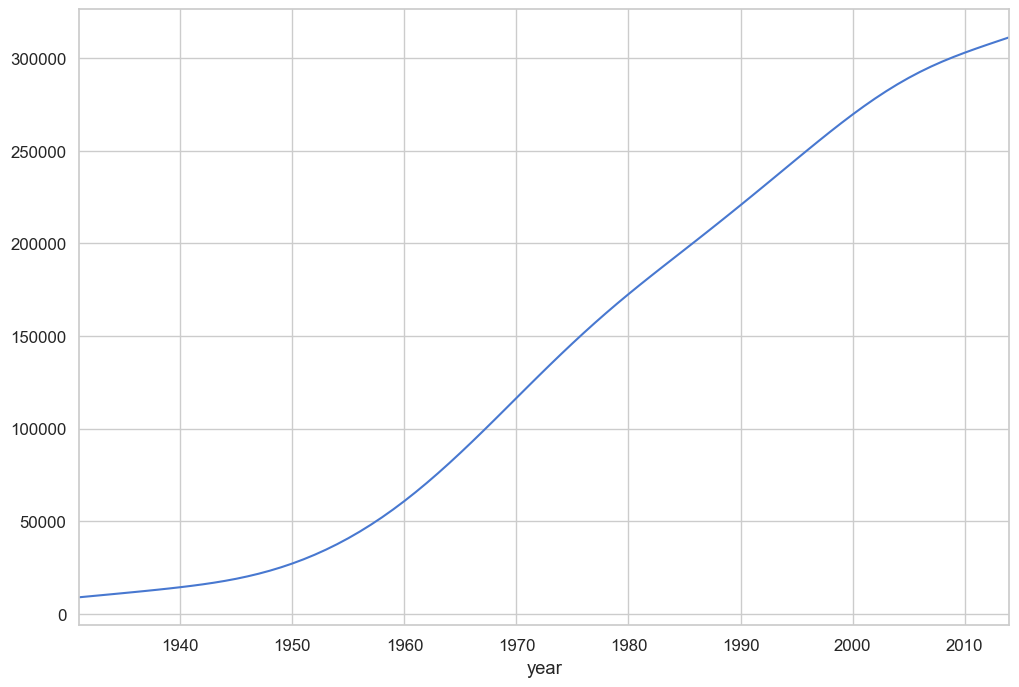

In [69]:
prod_trend.plot(figsize=(12,8))

In [70]:
data['production_trend'] = prod_trend

<Axes: xlabel='year'>

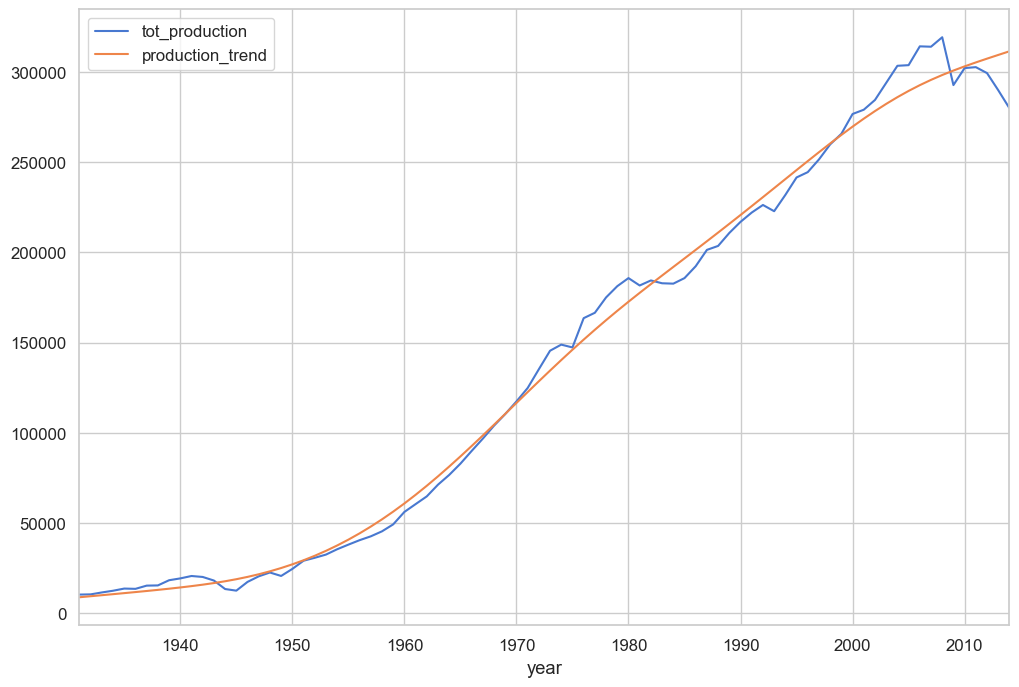

In [71]:
data[['tot_production','production_trend']].plot(figsize=(12,8))

In [72]:
cons_cycle,cons_trend = hpfilter(data['tot_consumption'])

In [73]:
data['consumption_trend'] = cons_trend

<Axes: xlabel='year'>

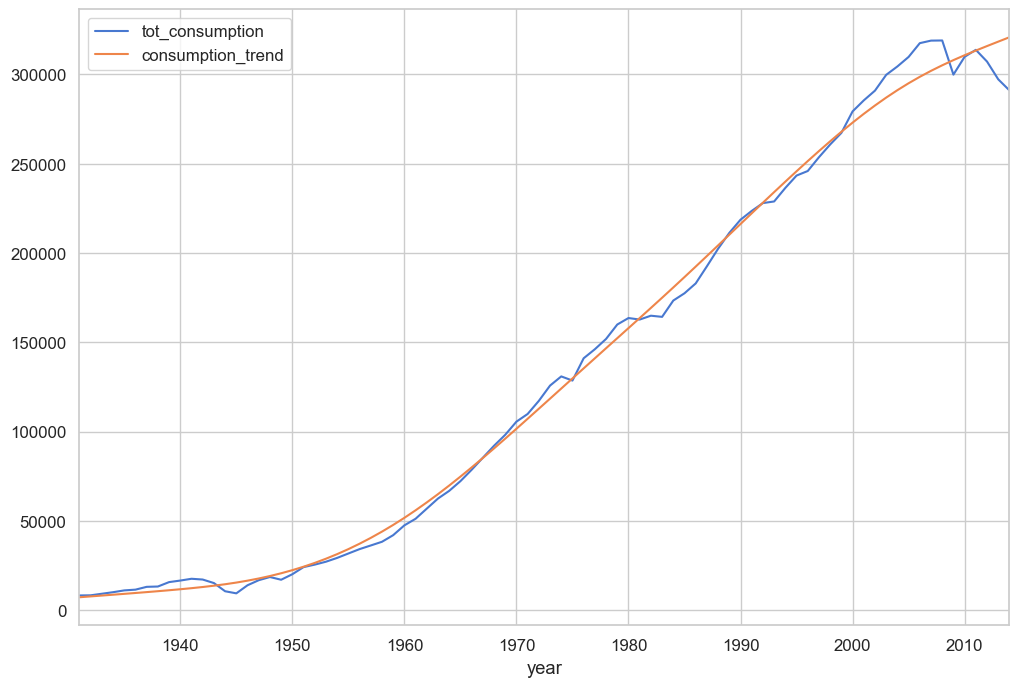

In [74]:
data[['tot_consumption','consumption_trend']].plot(figsize=(12,8))

<Axes: xlabel='year'>

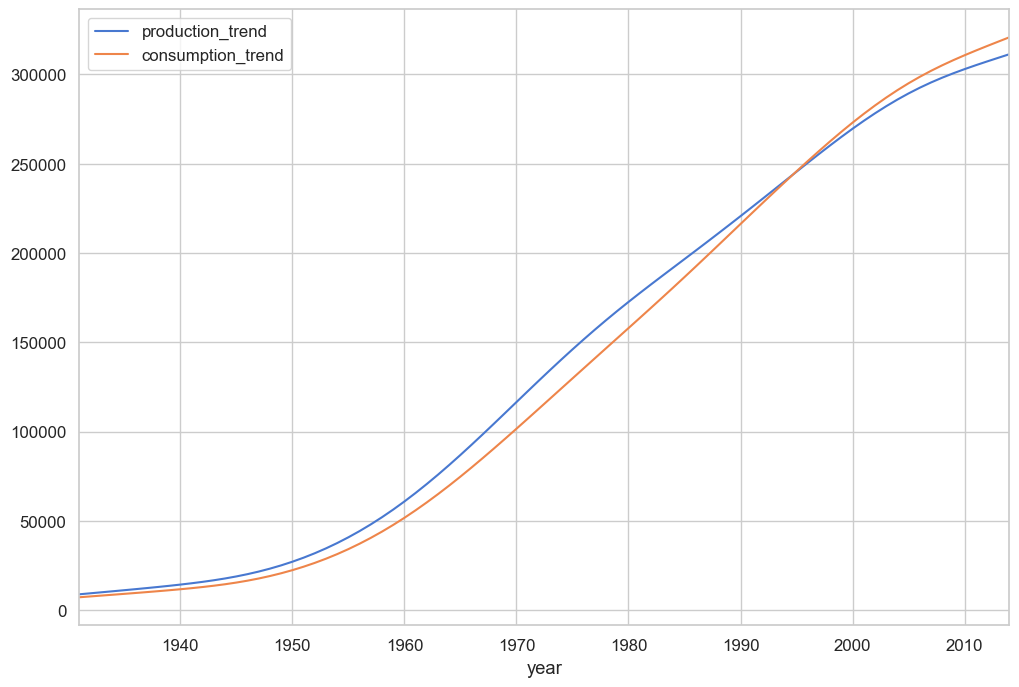

In [75]:
data[['production_trend','consumption_trend']].plot(figsize=(12,8))

<Axes: xlabel='year'>

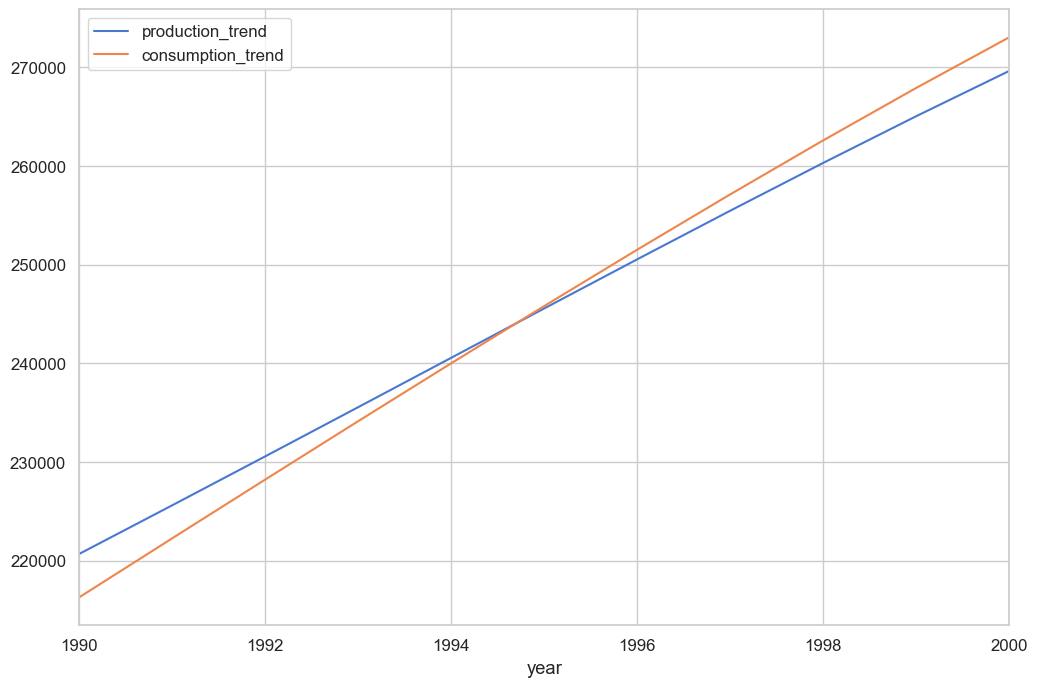

In [76]:
data[['production_trend','consumption_trend']].loc['1990-01-01':'2000-01-01'].plot(figsize=(12,8))

In [77]:
data['5-year-MA'] = data['tot_production'].rolling(window=5).mean()

In [78]:
data['10-year-MA'] = data['tot_production'].rolling(window=10).mean()

<Axes: xlabel='year'>

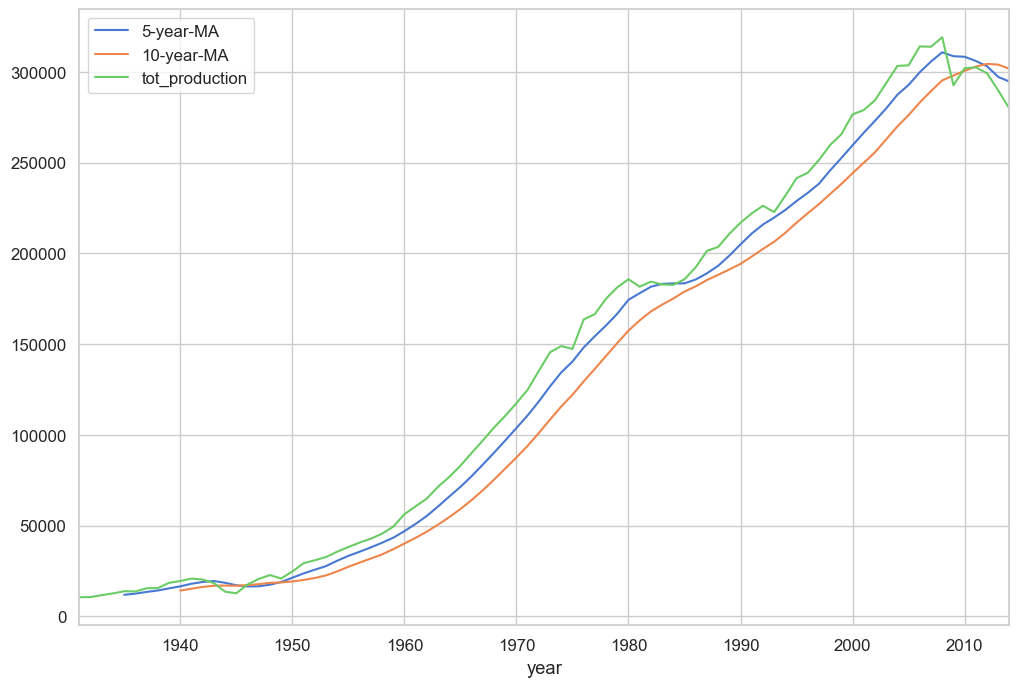

In [79]:
data[['5-year-MA','10-year-MA','tot_production']].plot(figsize=(12,8))

In [80]:
data.drop(['production_trend','consumption_trend','5-year-MA','10-year-MA'],axis=1,inplace=True)

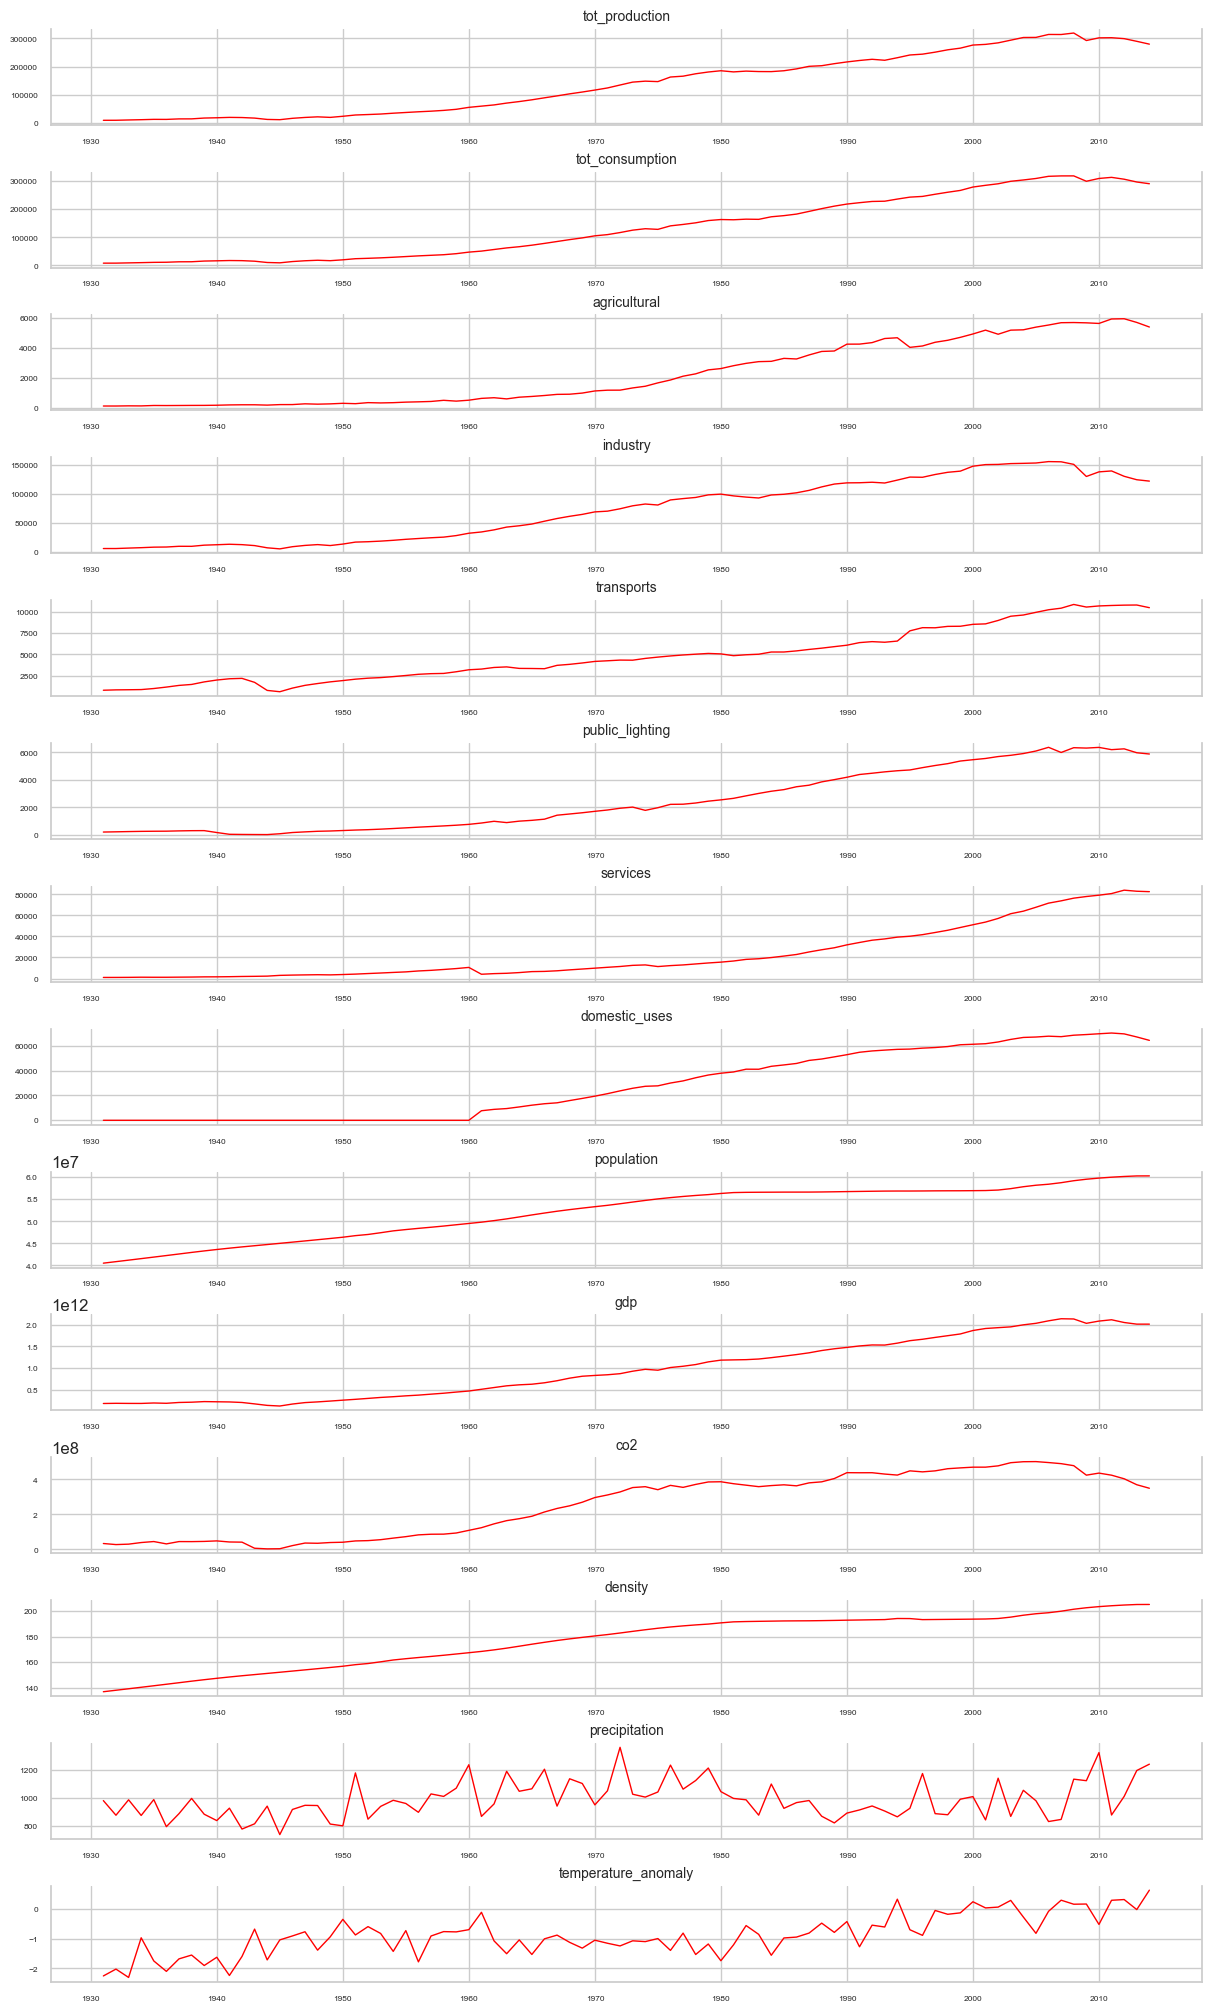

In [81]:
fig, axes = plt.subplots(nrows=data.shape[1],figsize=(12, 20),constrained_layout=True)

for i, ax in enumerate(axes):
    data_ = data[data.columns[i]]
    
    ax.plot(data_, color='red', linewidth=1)
    ax.set_title(data.columns[i], fontsize=10)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.show()

## last 30 years data

In [82]:
data_owid_italy = data_owid[data_owid['country'] == 'Italy'].copy()

In [83]:
data_owid_italy

country  year iso_code  population           gdp  \
9949    Italy  1900      ITA  33332371.0  1.099054e+11   
9950    Italy  1901      ITA  33571430.0  1.123700e+11   
9951    Italy  1902      ITA  33827207.0  1.151736e+11   
9952    Italy  1903      ITA  34099919.0  1.171513e+11   
9953    Italy  1904      ITA  34374827.0  1.201486e+11   
...       ...   ...      ...         ...           ...   
10068   Italy  2019      ITA  59727936.0  2.115726e+12   
10069   Italy  2020      ITA  59500576.0  1.925752e+12   
10070   Italy  2021      ITA  59240336.0  2.060300e+12   
10071   Italy  2022      ITA  59037472.0  2.136009e+12   
10072   Italy  2023      ITA  58870764.0           NaN   

       biofuel_cons_change_pct  biofuel_cons_change_twh  \
9949                       NaN                      NaN   
9950                       NaN                      NaN   
9951                       NaN                      NaN   
9952                       NaN                      NaN   
9953                       NaN                      NaN   
...                        ...                      ...   
10068                  -41.426                   -6.619   
10069                   41.324                    3.868   
10070                    4.498                    0.595   
10071                  -10.624                   -1.469   
10072                   14.866                    1.837   

       biofuel_cons_per_capita  biofuel_consumption  biofuel_elec_per_capita  \
9949                       NaN                  NaN                      NaN   
9950                       NaN                  NaN                      NaN   
9951                       NaN                  NaN                      NaN   
9952                       NaN                  NaN                      NaN   
9953                       NaN                  NaN                      NaN   
...                        ...                  ...                      ...   
10068                  156.700                9.359                  327.318   
10069                  222.302               13.227                  329.745   
10070                  233.321               13.822                  321.740   
10071                  209.248               12.353                  298.285   
10072                  241.037               14.190                  282.143   

       biofuel_electricity  biofuel_share_elec  biofuel_share_energy  \
9949                   NaN                 NaN                   NaN   
9950                   NaN                 NaN                   NaN   
9951                   NaN                 NaN                   NaN   
9952                   NaN                 NaN                   NaN   
9953                   NaN                 NaN                   NaN   
...                    ...                 ...                   ...   
10068                19.55               6.742                 0.514   
10069                19.62               7.088                 0.801   
10070                19.06               6.676                 0.782   
10071                17.61               6.290                 0.719   
10072                16.61               6.326                 0.859   

       carbon_intensity_elec  coal_cons_change_pct  coal_cons_change_twh  \
9949                     NaN                   NaN                   NaN   
9950                     NaN                   NaN                   NaN   
9951                     NaN                   NaN                   NaN   
9952                     NaN                   NaN                   NaN   
9953                     NaN                   NaN                   NaN   
...                      ...                   ...                   ...   
10068                351.288               -24.406               -25.033   
10069                334.273               -23.579               -18.282   
10070                339.276                10.007                 5.929   
10071         

In [84]:
data_owid_italy['year'] = pd.to_datetime(data_owid_italy['year'],format='%Y')

In [85]:
exclude_cols = ['electricity_demand','electricity_generation','net_elec_imports','carbon_intensity_elec','per_capita_electricity','electricity_demand_per_capita',
                'electricity_share_energy','net_elec_imports_share_demand']

cols = [col for col in data_owid_italy.columns if 'electricity' in col and col not in exclude_cols]

data_owid_electricity = pd.concat(
    [data_owid_italy[['year','population','gdp'] + exclude_cols],data_owid_italy[cols]],axis=1).set_index('year').dropna()

In [86]:
data_owid_share_elec = pd.concat(
     [data_owid_italy[['year','electricity_demand','electricity_generation']],
     data_owid_italy.filter(like='share_elec',axis=1)],axis=1).set_index('year').dropna()

In [87]:
data_owid_electricity = data_owid_electricity.merge(cpi,left_index=True,right_index=True,how='left')

In [88]:
data_owid_electricity.head() # electricity generation from xxx measured in terawatt-hours

population           gdp  electricity_demand  \
year                                                       
1990-01-01  56756560.0  1.475485e+12              247.80   
1991-01-01  56794488.0  1.509176e+12              253.51   
1992-01-01  56833184.0  1.531924e+12              257.98   
1993-01-01  56869456.0  1.529550e+12              259.17   
1994-01-01  56883820.0  1.573415e+12              266.35   

            electricity_generation  net_elec_imports  carbon_intensity_elec  \
year                                                                          
1990-01-01                  213.15             34.65                564.251   
1991-01-01                  218.43             35.08                533.764   
1992-01-01                  222.68             35.30                527.214   
1993-01-01                  219.74             39.43                517.566   
1994-01-01                  228.75             37.60                517.814   

            per_capita_electricity  electricity_demand_per_capita  \
year                                                                
1990-01-01                3755.513                       4366.015   
1991-01-01                3845.972                       4463.637   
1992-01-01                3918.133                       4539.250   
1993-01-01                3863.937                       4557.280   
1994-01-01                4021.354                       4682.351   

            electricity_share_energy  net_elec_imports_share_demand  \
year                                                                  
1990-01-01                    11.928                         13.983   
1991-01-01                    11.973                         13.838   
1992-01-01                    12.261                         13.683   
1993-01-01                    12.366                         15.214   
1994-01-01                    12.947                         14.117   

            biofuel_electricity  coal_electricity  fossil_electricity  \
year                                                                    
1990-01-01                 0.05             32.05              178.25   
1991-01-01                 0.11             28.50              172.90   
1992-01-01                 0.10             21.36              176.91   
1993-01-01                 0.12             16.66              174.52   
1994-01-01                 0.15             19.86              180.50   

            gas_electricity  hydro_electricity  low_carbon_electricity  \
year                                                                     
1990-01-01            39.71              31.63                   34.90   
1991-01-01            36.34              42.24                   45.53   
1992-01-01            35.48              42.20                   45.77   
1993-01-01            39.96              41.42                   45.22   
1994-01-01            40.80              44.66                   48.25   

            nuclear_electricity  oil_electricity  other_renewable_electricity  \
year                                                                            
1990-01-01                  0.0           106.49                         3.27   
1991-01-01                  0.0           108.06                         3.29   
1992-01-01                  0.0           120.07                         3.56   
1993-01-01                  0.0           117.90                         3.79   
1994-01-01                  0.0           119.84                         3.57   

            other_renewable_exc_biofuel_electricity  renewables_electricity  \
year                                                                          
1990-01-01                                     3.22                   34.90   
1991-01-01                                     3.18                   45.53   
1992-01-01                                     3.46                   45.77   
1993-01-01                                     3.67          

In [89]:
data_owid_electricity.head()

population           gdp  electricity_demand  \
year                                                       
1990-01-01  56756560.0  1.475485e+12              247.80   
1991-01-01  56794488.0  1.509176e+12              253.51   
1992-01-01  56833184.0  1.531924e+12              257.98   
1993-01-01  56869456.0  1.529550e+12              259.17   
1994-01-01  56883820.0  1.573415e+12              266.35   

            electricity_generation  net_elec_imports  carbon_intensity_elec  \
year                                                                          
1990-01-01                  213.15             34.65                564.251   
1991-01-01                  218.43             35.08                533.764   
1992-01-01                  222.68             35.30                527.214   
1993-01-01                  219.74             39.43                517.566   
1994-01-01                  228.75             37.60                517.814   

            per_capita_electricity  electricity_demand_per_capita  \
year                                                                
1990-01-01                3755.513                       4366.015   
1991-01-01                3845.972                       4463.637   
1992-01-01                3918.133                       4539.250   
1993-01-01                3863.937                       4557.280   
1994-01-01                4021.354                       4682.351   

            electricity_share_energy  net_elec_imports_share_demand  \
year                                                                  
1990-01-01                    11.928                         13.983   
1991-01-01                    11.973                         13.838   
1992-01-01                    12.261                         13.683   
1993-01-01                    12.366                         15.214   
1994-01-01                    12.947                         14.117   

            biofuel_electricity  coal_electricity  fossil_electricity  \
year                                                                    
1990-01-01                 0.05             32.05              178.25   
1991-01-01                 0.11             28.50              172.90   
1992-01-01                 0.10             21.36              176.91   
1993-01-01                 0.12             16.66              174.52   
1994-01-01                 0.15             19.86              180.50   

            gas_electricity  hydro_electricity  low_carbon_electricity  \
year                                                                     
1990-01-01            39.71              31.63                   34.90   
1991-01-01            36.34              42.24                   45.53   
1992-01-01            35.48              42.20                   45.77   
1993-01-01            39.96              41.42                   45.22   
1994-01-01            40.80              44.66                   48.25   

            nuclear_electricity  oil_electricity  other_renewable_electricity  \
year                                                                            
1990-01-01                  0.0           106.49                         3.27   
1991-01-01                  0.0           108.06                         3.29   
1992-01-01                  0.0           120.07                         3.56   
1993-01-01                  0.0           117.90                         3.79   
1994-01-01                  0.0           119.84                         3.57   

            other_renewable_exc_biofuel_electricity  renewables_electricity  \
year                                                                          
1990-01-01                                     3.22                   34.90   
1991-01-01                                     3.18                   45.53   
1992-01-01                                     3.46                   45.77   
1993-01-01                                     3.67          

In [90]:
data_owid_share_elec.head() # share of electricity generated by xxx measured as a percentage of total electricity

electricity_demand  electricity_generation  biofuel_share_elec  \
year                                                                         
1990-01-01              247.80                  213.15               0.023   
1991-01-01              253.51                  218.43               0.050   
1992-01-01              257.98                  222.68               0.045   
1993-01-01              259.17                  219.74               0.055   
1994-01-01              266.35                  228.75               0.066   

            coal_share_elec  fossil_share_elec  gas_share_elec  \
year                                                             
1990-01-01           15.036             83.627          18.630   
1991-01-01           13.048             79.156          16.637   
1992-01-01            9.592             79.446          15.933   
1993-01-01            7.582             79.421          18.185   
1994-01-01            8.682             78.907          17.836   

            hydro_share_elec  low_carbon_share_elec  nuclear_share_elec  \
year                                                                      
1990-01-01            14.839                 16.373                 0.0   
1991-01-01            19.338                 20.844                 0.0   
1992-01-01            18.951                 20.554                 0.0   
1993-01-01            18.850                 20.579                 0.0   
1994-01-01            19.523                 21.093                 0.0   

            oil_share_elec  other_renewables_share_elec  \
year                                                      
1990-01-01          49.960                        1.534   
1991-01-01          49.471                        1.506   
1992-01-01          53.920                        1.599   
1993-01-01          53.654                        1.725   
1994-01-01          52.389                        1.561   

            other_renewables_share_elec_exc_biofuel  renewables_share_elec  \
year                                                                         
1990-01-01                                    1.511                 16.373   
1991-01-01                                    1.456                 20.844   
1992-01-01                                    1.554                 20.554   
1993-01-01                                    1.670                 20.579   
1994-01-01                                    1.495                 21.093   

            solar_share_elec  wind_share_elec  
year                                           
1990-01-01             0.000            0.000  
1991-01-01             0.000            0.000  
1992-01-01             0.004            0.000  
1993-01-01             0.005            0.000  
1994-01-01             0.004            0.004

<Axes: xlabel='year'>

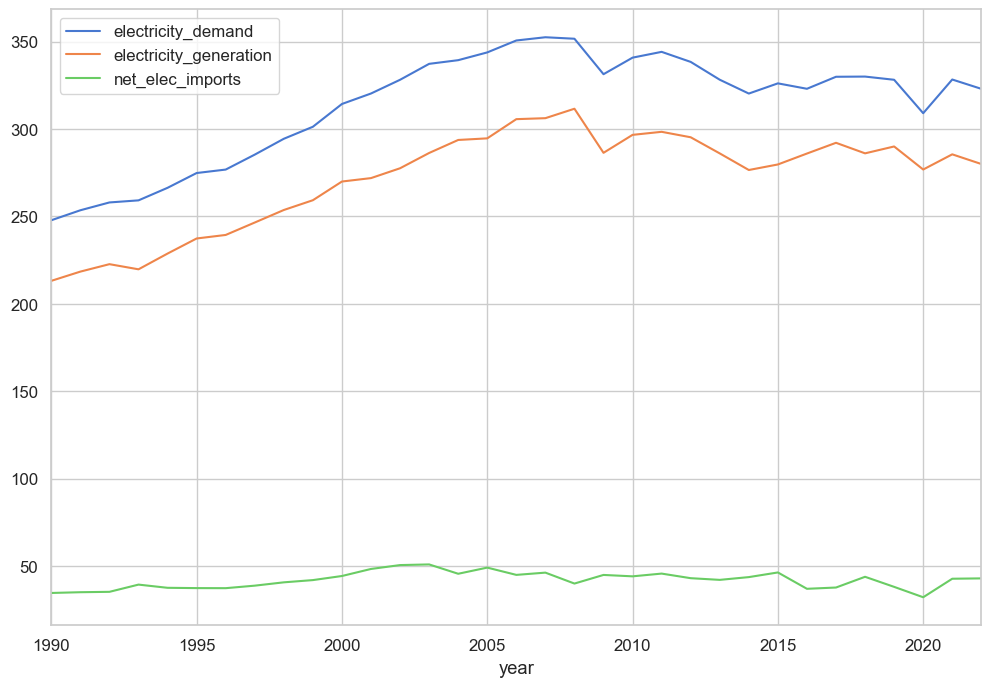

In [91]:
data_owid_electricity[['electricity_demand','electricity_generation','net_elec_imports']].plot(figsize=(12,8))

<Axes: xlabel='year'>

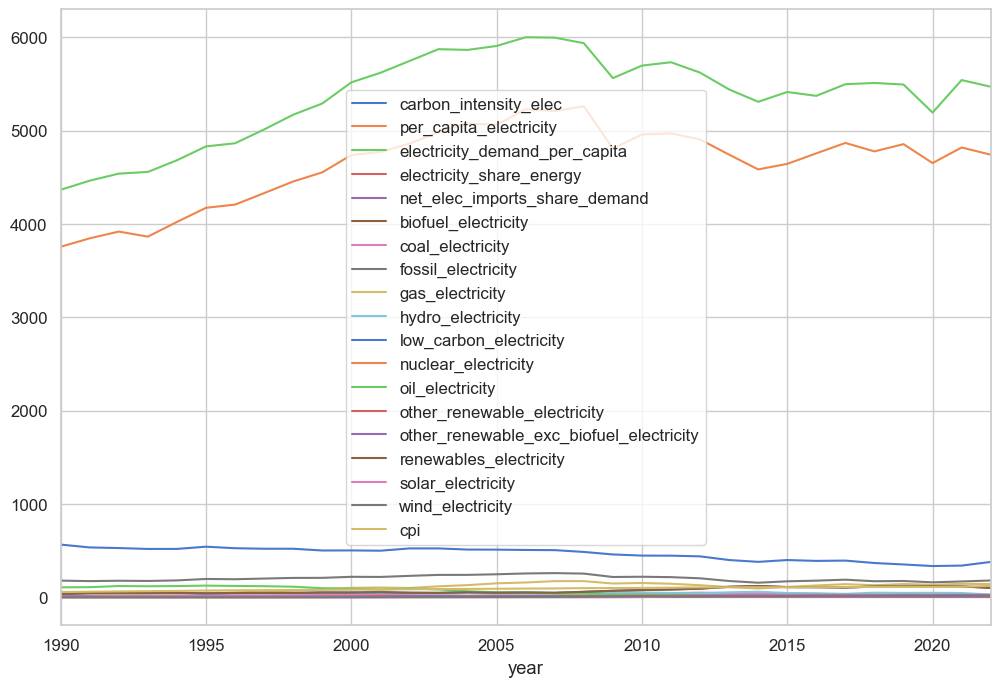

In [92]:
data_owid_electricity.drop(['population','gdp','electricity_demand','electricity_generation','net_elec_imports'],axis=1).plot(figsize=(12,8))

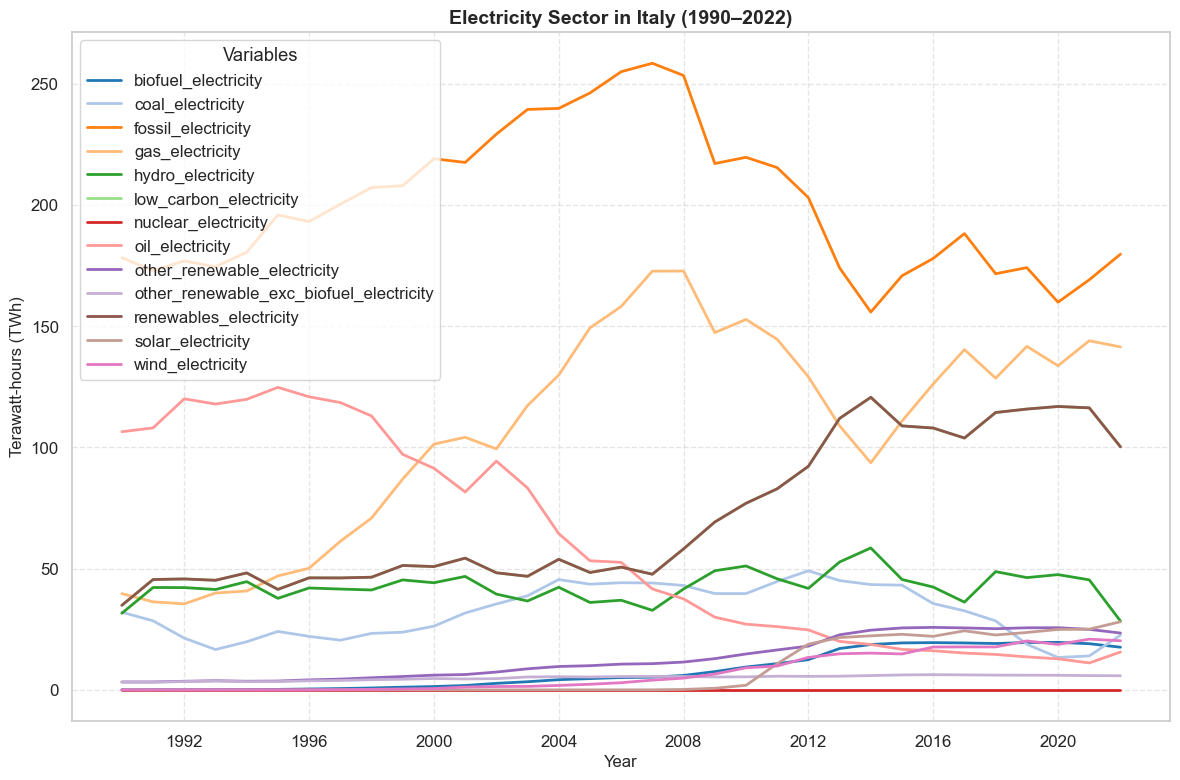

In [93]:
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.figure(figsize=(12,8))

colors = plt.get_cmap('tab20').colors

columns =  ['biofuel_electricity',
       'coal_electricity', 'fossil_electricity', 'gas_electricity',
       'hydro_electricity', 'low_carbon_electricity', 'nuclear_electricity',
       'oil_electricity', 'other_renewable_electricity',
       'other_renewable_exc_biofuel_electricity', 'renewables_electricity',
       'solar_electricity', 'wind_electricity']
    
for i, column in enumerate(columns):
    plt.plot(
        data_owid_electricity.index,
        data_owid_electricity[column],
        label=column,
        color=colors[i % len(colors)],
        linewidth=2
)

plt.title('Electricity Sector in Italy (1990–2022)', fontsize=14, weight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Terawatt-hours (TWh)', fontsize=12)
plt.legend(loc='upper left', title="Variables")

plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [94]:
data_owid_electricity.columns

Index(['population', 'gdp', 'electricity_demand', 'electricity_generation',
       'net_elec_imports', 'carbon_intensity_elec', 'per_capita_electricity',
       'electricity_demand_per_capita', 'electricity_share_energy',
       'net_elec_imports_share_demand', 'biofuel_electricity',
       'coal_electricity', 'fossil_electricity', 'gas_electricity',
       'hydro_electricity', 'low_carbon_electricity', 'nuclear_electricity',
       'oil_electricity', 'other_renewable_electricity',
       'other_renewable_exc_biofuel_electricity', 'renewables_electricity',
       'solar_electricity', 'wind_electricity', 'cpi'],
      dtype='object')

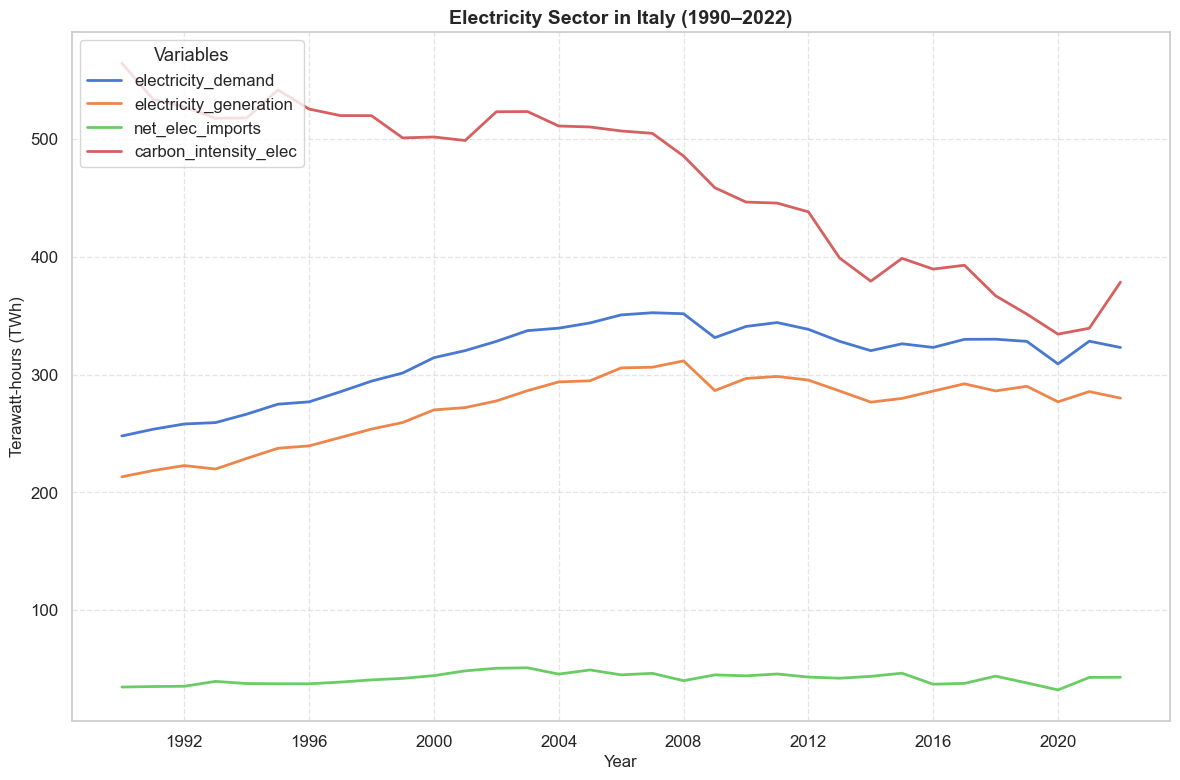

In [95]:
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.figure(figsize=(12,8))

for column in ['electricity_demand', 'electricity_generation',
       'net_elec_imports', 'carbon_intensity_elec']:
    plt.plot(data_owid_electricity.index, data_owid_electricity[column], label=column, linewidth=2)

plt.title('Electricity Sector in Italy (1990–2022)', fontsize=14, weight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Terawatt-hours (TWh)', fontsize=12)
plt.legend(loc='upper left', title="Variables")

plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

<Axes: xlabel='year'>

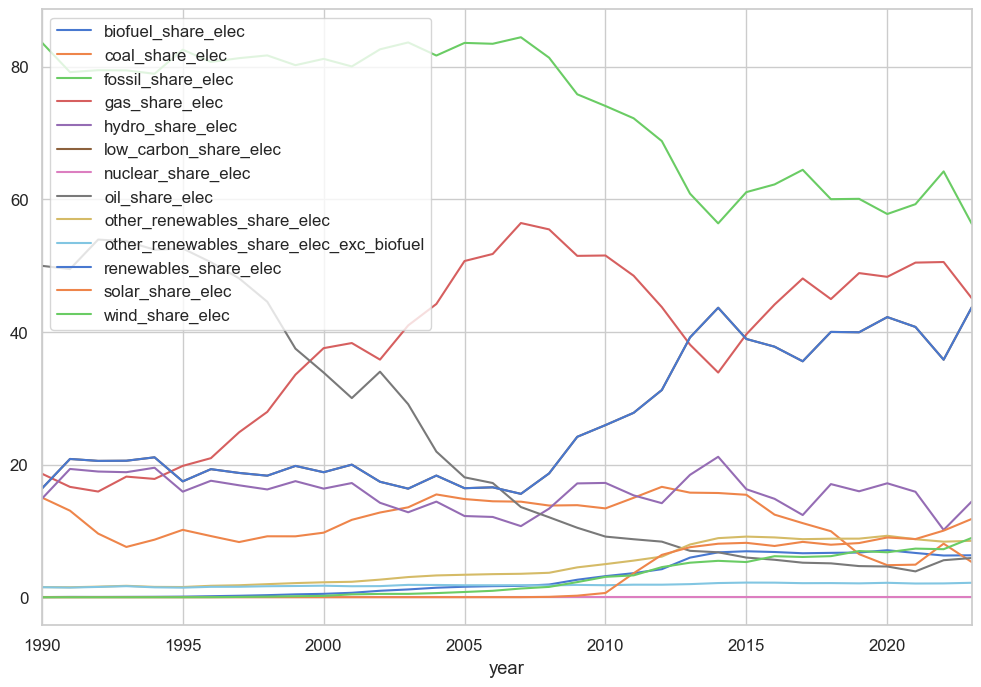

In [96]:
data_owid_share_elec.drop(['electricity_demand','electricity_generation'],axis=1).plot(figsize=(12,8))

In [97]:
data_owid_electricity['per_capita_gdp'] = data_owid_electricity['gdp'] / data_owid_electricity['population']

In [98]:
data_owid_electricity['per_capita_gdp'] = data_owid_electricity['per_capita_gdp'] / 100

## var model dataset

In [99]:
data_normalized.head()

tot_production  tot_consumption  agricultural  industry  \
year                                                                  
1931-01-01       -1.216253        -1.155171     -1.027098 -1.280093   
1932-01-01       -1.215125        -1.154396     -1.027098 -1.279903   
1933-01-01       -1.205159        -1.146435     -1.021802 -1.265418   
1934-01-01       -1.196226        -1.138539     -1.023728 -1.252093   
1935-01-01       -1.184943        -1.129338     -1.010246 -1.234981   

            transports  public_lighting  services  domestic_uses  population  \
year                                                                           
1931-01-01   -1.305079        -1.035021 -0.874326      -1.063601   -1.977532   
1932-01-01   -1.291524        -1.027825 -0.873664      -1.063601   -1.919466   
1933-01-01   -1.286683        -1.019729 -0.871015      -1.063601   -1.861377   
1934-01-01   -1.280551        -1.012982 -0.865718      -1.063601   -1.802801   
1935-01-01   -1.240531        -1.008934 -0.867705      -1.063601   -1.743734   

                 gdp       co2   density  precipitation  temperature_anomaly  
year                                                                          
1931-01-01 -1.169514 -1.268917 -1.959790      -0.046158            -2.024573  
1932-01-01 -1.163626 -1.303621 -1.902889      -0.836389            -1.685192  
1933-01-01 -1.166847 -1.289933 -1.845964      -0.002455            -2.098993  
1934-01-01 -1.167560 -1.237735 -1.788561      -0.847495            -0.133632  
1935-01-01 -1.152642 -1.205263 -1.730679       0.009240            -1.280007

In [100]:
data_normalized.columns

Index(['tot_production', 'tot_consumption', 'agricultural', 'industry',
       'transports', 'public_lighting', 'services', 'domestic_uses',
       'population', 'gdp', 'co2', 'density', 'precipitation',
       'temperature_anomaly'],
      dtype='object')

In [101]:
var_data = data_normalized[['tot_production','gdp','co2','tot_consumption']]

<Axes: xlabel='year'>

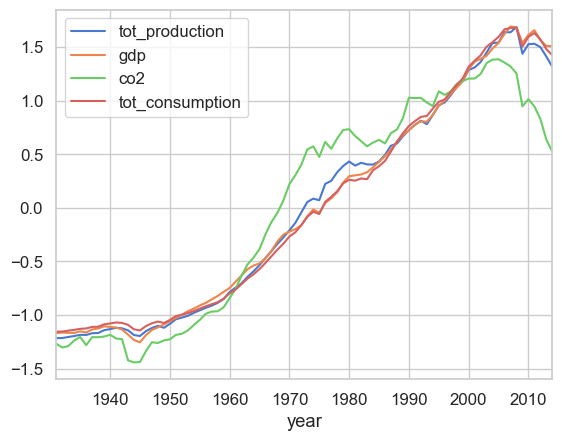

In [102]:
var_data.plot()

In [103]:
cons_cycle,cons_trend = hpfilter(data['tot_consumption'])

In [104]:
data['consumption_trend'] = cons_trend

<Axes: xlabel='year'>

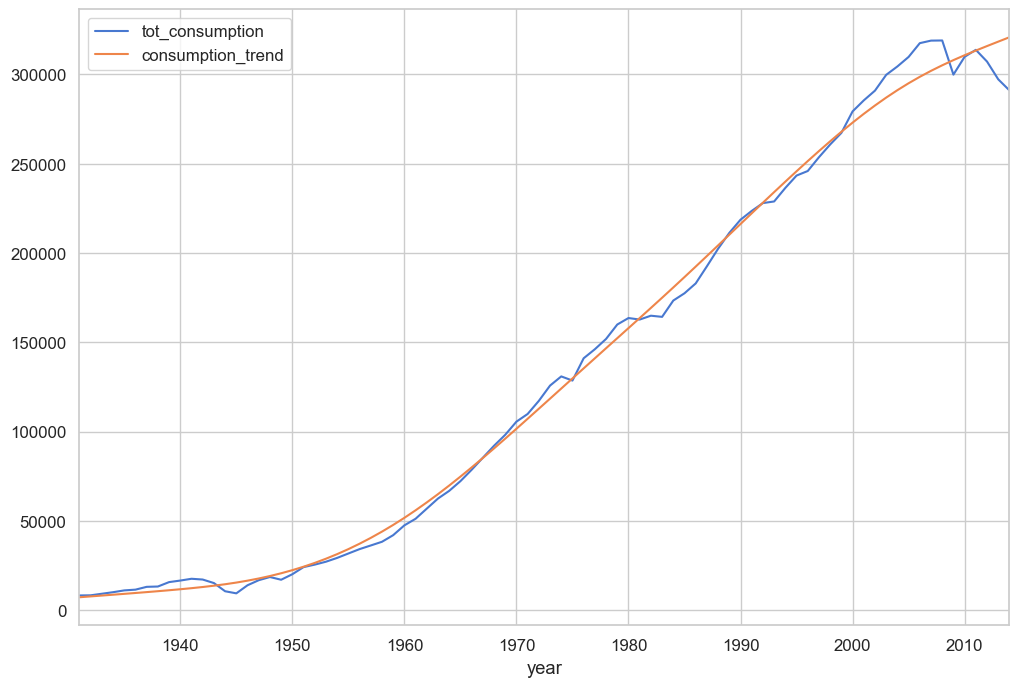

In [105]:
data[['tot_consumption','consumption_trend']].plot(figsize=(12,8))

In [106]:
cons_cycle,cons_trend = hpfilter(data['tot_production'])

In [107]:
data['total_production_trend'] = cons_trend

<Axes: xlabel='year'>

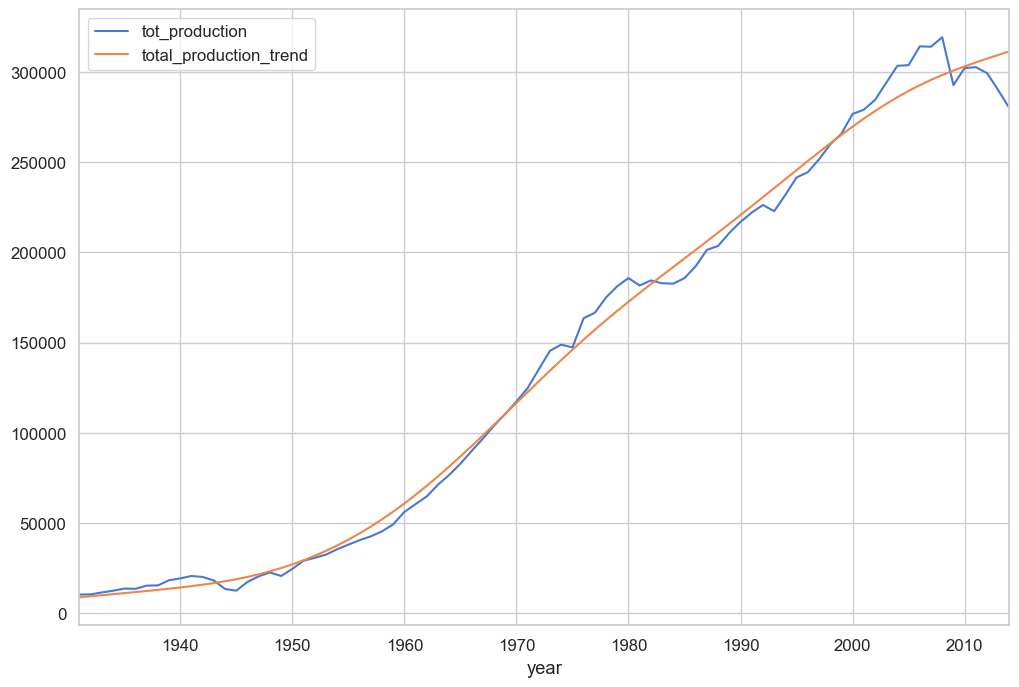

In [108]:
data[['tot_production','total_production_trend']].plot(figsize=(12,8))

In [109]:
data['10-year-MA'] = data['tot_production'].rolling(window=10).mean()

<Axes: xlabel='year'>

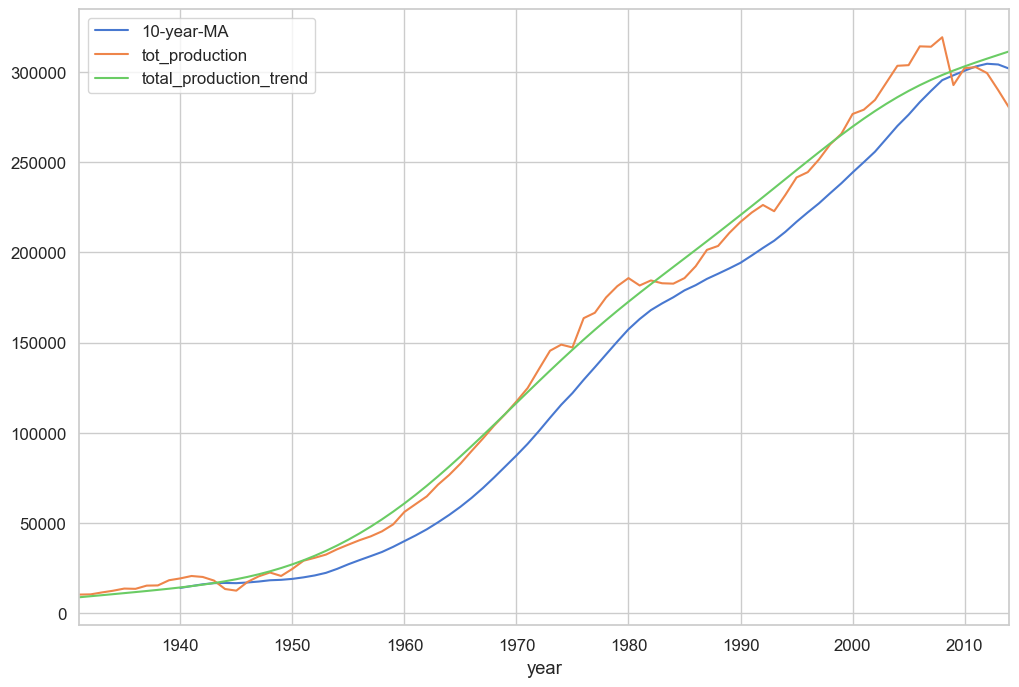

In [110]:
data[['10-year-MA','tot_production','total_production_trend']].plot(figsize=(12,8))

<Figure size 1200x800 with 0 Axes>

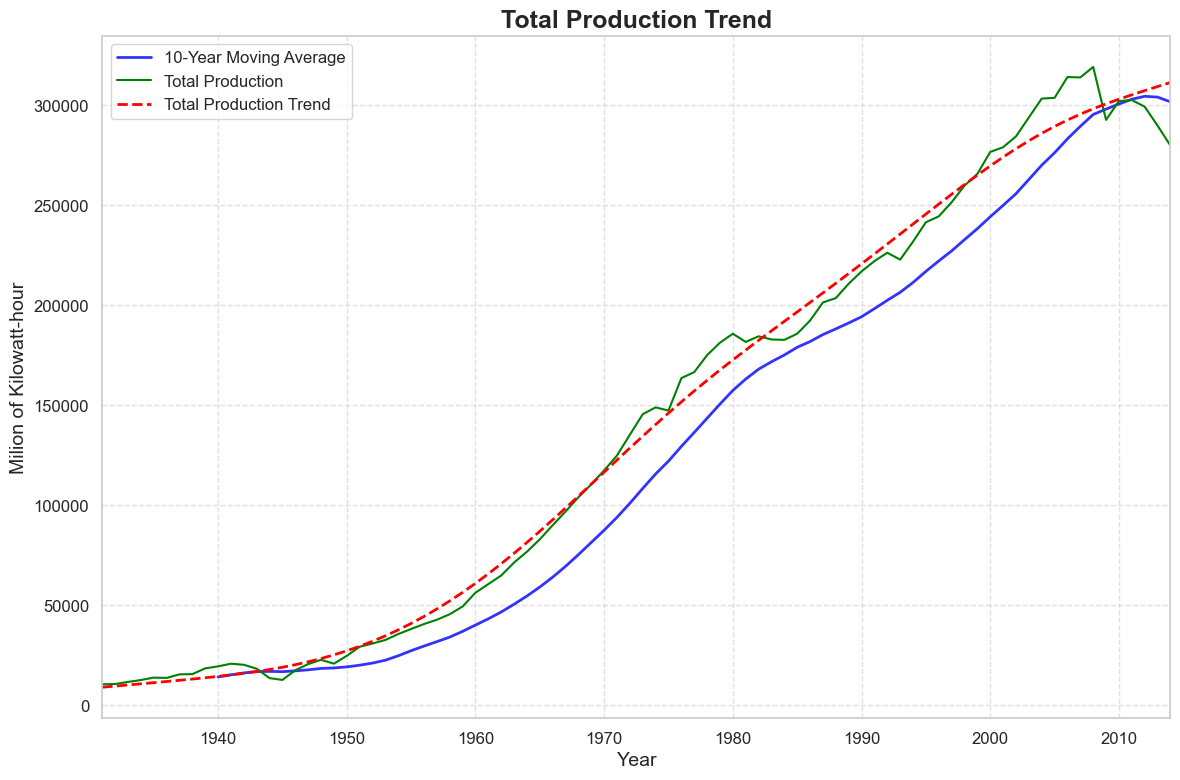

In [111]:
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.figure(figsize=(12,8))

fig, ax = plt.subplots(figsize=(12, 8))


data['10-year-MA'].plot(ax=ax, label='10-Year Moving Average', color='blue', linewidth=2,alpha=0.8)
data['tot_production'].plot(ax=ax, label='Total Production', color='green')
data['total_production_trend'].plot(ax=ax, label='Total Production Trend', color='red', linestyle='--', linewidth=2)

ax.set_title('Total Production Trend', fontsize=18, fontweight='bold')
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Milion of Kilowatt-hour', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=12)
ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()

## monthly data

In [112]:
prices = pd.read_csv('./dataset/elec_prices.csv')

In [113]:
prices.head()

observation_date  CP0451ITM086NEST
0       1996-01-01              69.5
1       1996-02-01              69.5
2       1996-03-01              69.5
3       1996-04-01              69.5
4       1996-05-01              69.5

In [114]:
prices.tail()

observation_date  CP0451ITM086NEST
346       2024-11-01             179.6
347       2024-12-01             180.5
348       2025-01-01             194.2
349       2025-02-01             195.2
350       2025-03-01             197.5

In [115]:
prices.rename(columns={'CP0451ITM086NEST': 'electricity_price'}, inplace=True)

In [116]:
prices

observation_date  electricity_price
0         1996-01-01               69.5
1         1996-02-01               69.5
2         1996-03-01               69.5
3         1996-04-01               69.5
4         1996-05-01               69.5
..               ...                ...
346       2024-11-01              179.6
347       2024-12-01              180.5
348       2025-01-01              194.2
349       2025-02-01              195.2
350       2025-03-01              197.5

[351 rows x 2 columns]

In [117]:
prices['observation_date'] = pd.to_datetime(prices['observation_date'],format='%Y-%m-%d')

In [118]:
prices.set_index('observation_date',inplace=True)

In [119]:
prices

electricity_price
observation_date                   
1996-01-01                     69.5
1996-02-01                     69.5
1996-03-01                     69.5
1996-04-01                     69.5
1996-05-01                     69.5
...                             ...
2024-11-01                    179.6
2024-12-01                    180.5
2025-01-01                    194.2
2025-02-01                    195.2
2025-03-01                    197.5

[351 rows x 1 columns]

<Axes: xlabel='observation_date'>

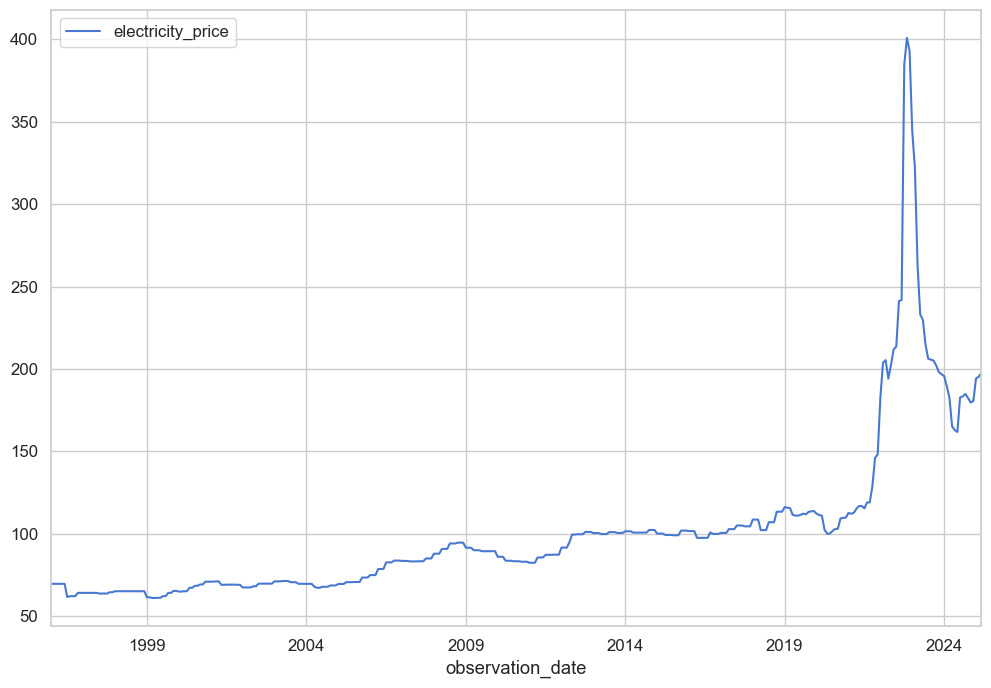

In [120]:
prices.plot(figsize=(12,8))

In [121]:
month_temperature = pd.read_csv('./dataset/monthly-temperature-anomalies.csv')

In [122]:
month_temperature

Entity Code         Day  Temperature anomaly
0     Italy  ITA  1940-01-15            -5.170999
1     Italy  ITA  1940-02-15            -2.872476
2     Italy  ITA  1940-03-15            -2.752496
3     Italy  ITA  1940-04-15            -1.622283
4     Italy  ITA  1940-05-15            -1.345494
...     ...  ...         ...                  ...
1018  Italy  ITA  2024-11-15             0.294782
1019  Italy  ITA  2024-12-15             0.432432
1020  Italy  ITA  2025-01-15             1.926028
1021  Italy  ITA  2025-02-15             1.497018
1022  Italy  ITA  2025-03-15             1.195309

[1023 rows x 4 columns]

In [123]:
month_temperature.drop(['Entity','Code'],axis=1,inplace=True)

In [124]:
month_temperature['Day'] = pd.to_datetime(month_temperature['Day'],format='%Y-%m-%d')

In [125]:
month_temperature.set_index('Day',inplace=True)

In [126]:
month_temperature

Temperature anomaly
Day                            
1940-01-15            -5.170999
1940-02-15            -2.872476
1940-03-15            -2.752496
1940-04-15            -1.622283
1940-05-15            -1.345494
...                         ...
2024-11-15             0.294782
2024-12-15             0.432432
2025-01-15             1.926028
2025-02-15             1.497018
2025-03-15             1.195309

[1023 rows x 1 columns]

In [127]:
month_temperature.index = month_temperature.index.to_period('M').to_timestamp()

In [128]:
month_temperature

Temperature anomaly
Day                            
1940-01-01            -5.170999
1940-02-01            -2.872476
1940-03-01            -2.752496
1940-04-01            -1.622283
1940-05-01            -1.345494
...                         ...
2024-11-01             0.294782
2024-12-01             0.432432
2025-01-01             1.926028
2025-02-01             1.497018
2025-03-01             1.195309

[1023 rows x 1 columns]

In [129]:
month_temperature.rename(columns={'Temperature anomaly': 'temperature_anomaly'},inplace=True)

<Axes: xlabel='Day'>

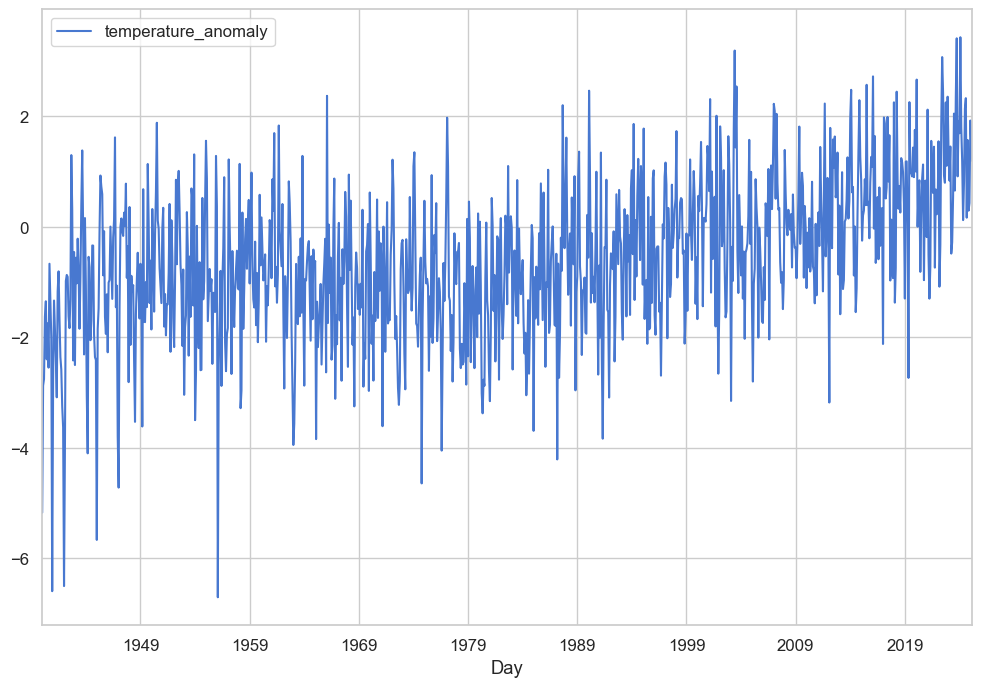

In [130]:
month_temperature.plot(figsize=(12,8))

In [131]:
gas = pd.read_csv('./dataset/gas.csv')

In [132]:
gas.head()

observation_date  CP0452ITM086NEST
0       1996-01-01              58.0
1       1996-02-01              58.1
2       1996-03-01              58.1
3       1996-04-01              58.1
4       1996-05-01              58.1

In [133]:
gas.tail()

observation_date  CP0452ITM086NEST
346       2024-11-01             153.2
347       2024-12-01             153.9
348       2025-01-01             156.0
349       2025-02-01             156.0
350       2025-03-01             160.8

In [134]:
gas.rename(columns={'CP0452ITM086NEST': 'gas_price'}, inplace=True)

In [135]:
gas

observation_date  gas_price
0         1996-01-01       58.0
1         1996-02-01       58.1
2         1996-03-01       58.1
3         1996-04-01       58.1
4         1996-05-01       58.1
..               ...        ...
346       2024-11-01      153.2
347       2024-12-01      153.9
348       2025-01-01      156.0
349       2025-02-01      156.0
350       2025-03-01      160.8

[351 rows x 2 columns]

In [136]:
gas['observation_date'] = pd.to_datetime(gas['observation_date'],format='%Y-%m-%d')

In [137]:
gas.set_index('observation_date',inplace=True)

In [138]:
gas

gas_price
observation_date           
1996-01-01             58.0
1996-02-01             58.1
1996-03-01             58.1
1996-04-01             58.1
1996-05-01             58.1
...                     ...
2024-11-01            153.2
2024-12-01            153.9
2025-01-01            156.0
2025-02-01            156.0
2025-03-01            160.8

[351 rows x 1 columns]

<Axes: xlabel='observation_date'>

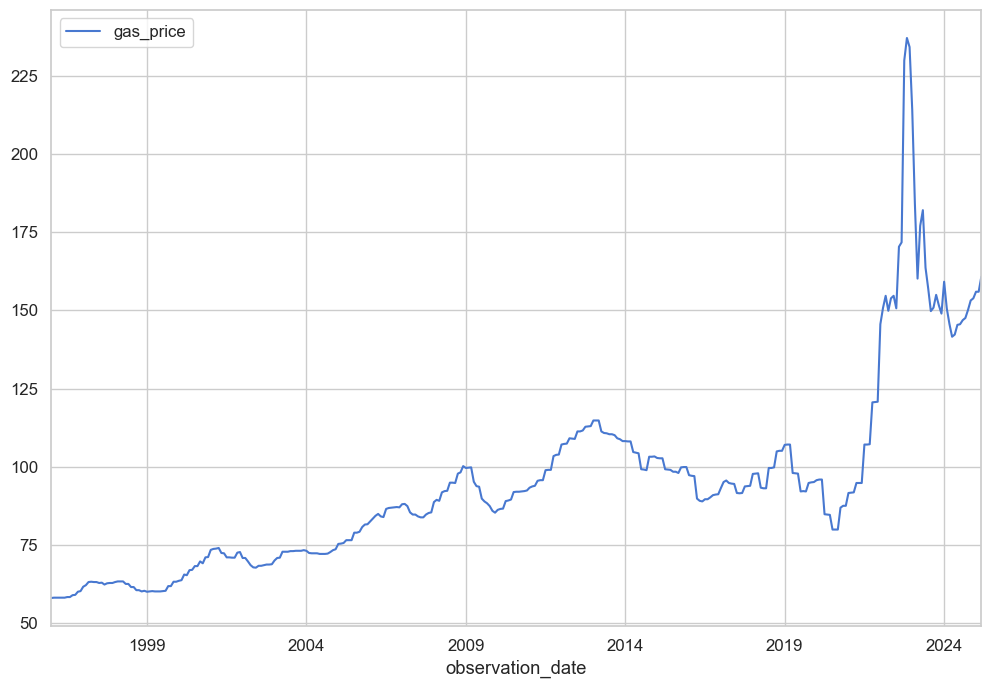

In [139]:
gas.plot(figsize=(12,8))

In [140]:
cpi_month = pd.read_csv('./dataset/cpi.csv')

In [141]:
cpi_month.head()

observation_date  CPALTT01ITM659N
0       1956-01-01         1.811249
1       1956-02-01         3.154876
2       1956-03-01         3.824092
3       1956-04-01         4.007634
4       1956-05-01         4.099142

In [142]:
cpi_month.tail()

observation_date  CPALTT01ITM659N
825       2024-10-01         0.915903
826       2024-11-01         1.338912
827       2024-12-01         1.253133
828       2025-01-01         1.498751
829       2025-02-01         1.580699

In [143]:
cpi_month.rename(columns={'CPALTT01ITM659N': 'cpi'}, inplace=True)

In [144]:
cpi_month

observation_date       cpi
0         1956-01-01  1.811249
1         1956-02-01  3.154876
2         1956-03-01  3.824092
3         1956-04-01  4.007634
4         1956-05-01  4.099142
..               ...       ...
825       2024-10-01  0.915903
826       2024-11-01  1.338912
827       2024-12-01  1.253133
828       2025-01-01  1.498751
829       2025-02-01  1.580699

[830 rows x 2 columns]

In [145]:
cpi_month['observation_date'] = pd.to_datetime(cpi_month['observation_date'],format='%Y-%m-%d')

In [146]:
cpi_month.set_index('observation_date',inplace=True)

In [147]:
cpi_month

cpi
observation_date          
1956-01-01        1.811249
1956-02-01        3.154876
1956-03-01        3.824092
1956-04-01        4.007634
1956-05-01        4.099142
...                    ...
2024-10-01        0.915903
2024-11-01        1.338912
2024-12-01        1.253133
2025-01-01        1.498751
2025-02-01        1.580699

[830 rows x 1 columns]

<Axes: xlabel='observation_date'>

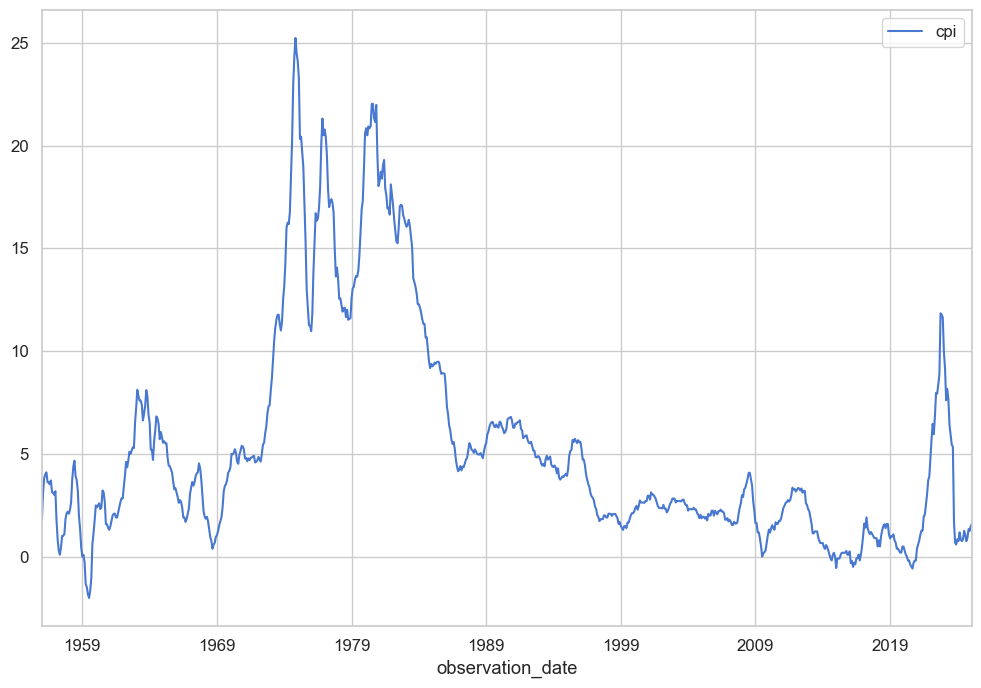

In [148]:
cpi_month.plot(figsize=(12,8))

In [149]:
prices = prices.merge(month_temperature,left_index=True,right_index=True,how='left').merge(
    gas,left_index=True,right_index=True,how='left').merge(
        cpi_month,left_index=True,right_index=True,how='left')

In [150]:
prices.dropna(inplace=True)

In [151]:
prices

electricity_price  temperature_anomaly  gas_price       cpi
observation_date                                                             
1996-01-01                     69.5             1.023996       58.0  5.581592
1996-02-01                     69.5            -1.598339       58.1  5.232290
1996-03-01                     69.5            -1.951190       58.1  4.722010
1996-04-01                     69.5            -0.395774       58.1  4.713302
1996-05-01                     69.5            -0.354135       58.1  4.458684
...                             ...                  ...        ...       ...
2024-10-01                    182.3             1.573842      150.2  0.915903
2024-11-01                    179.6             0.294782      153.2  1.338912
2024-12-01                    180.5             0.432432      153.9  1.253133
2025-01-01                    194.2             1.926028      156.0  1.498751
2025-02-01                    195.2             1.497018      156.0  1.580699

[350 rows x 4 columns]

<Axes: xlabel='observation_date'>

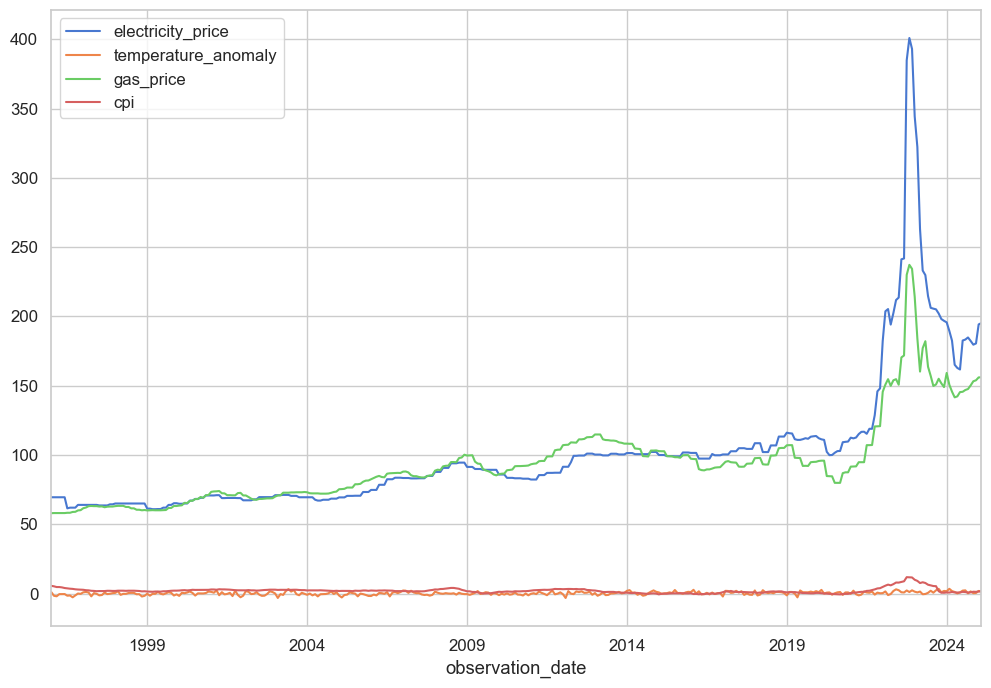

In [152]:
prices.plot(figsize=(12,8))

In [153]:
prices.shape

(350, 4)

In [154]:
prices.head()

electricity_price  temperature_anomaly  gas_price       cpi
observation_date                                                             
1996-01-01                     69.5             1.023996       58.0  5.581592
1996-02-01                     69.5            -1.598339       58.1  5.232290
1996-03-01                     69.5            -1.951190       58.1  4.722010
1996-04-01                     69.5            -0.395774       58.1  4.713302
1996-05-01                     69.5            -0.354135       58.1  4.458684

In [155]:
prices.tail()

electricity_price  temperature_anomaly  gas_price       cpi
observation_date                                                             
2024-10-01                    182.3             1.573842      150.2  0.915903
2024-11-01                    179.6             0.294782      153.2  1.338912
2024-12-01                    180.5             0.432432      153.9  1.253133
2025-01-01                    194.2             1.926028      156.0  1.498751
2025-02-01                    195.2             1.497018      156.0  1.580699

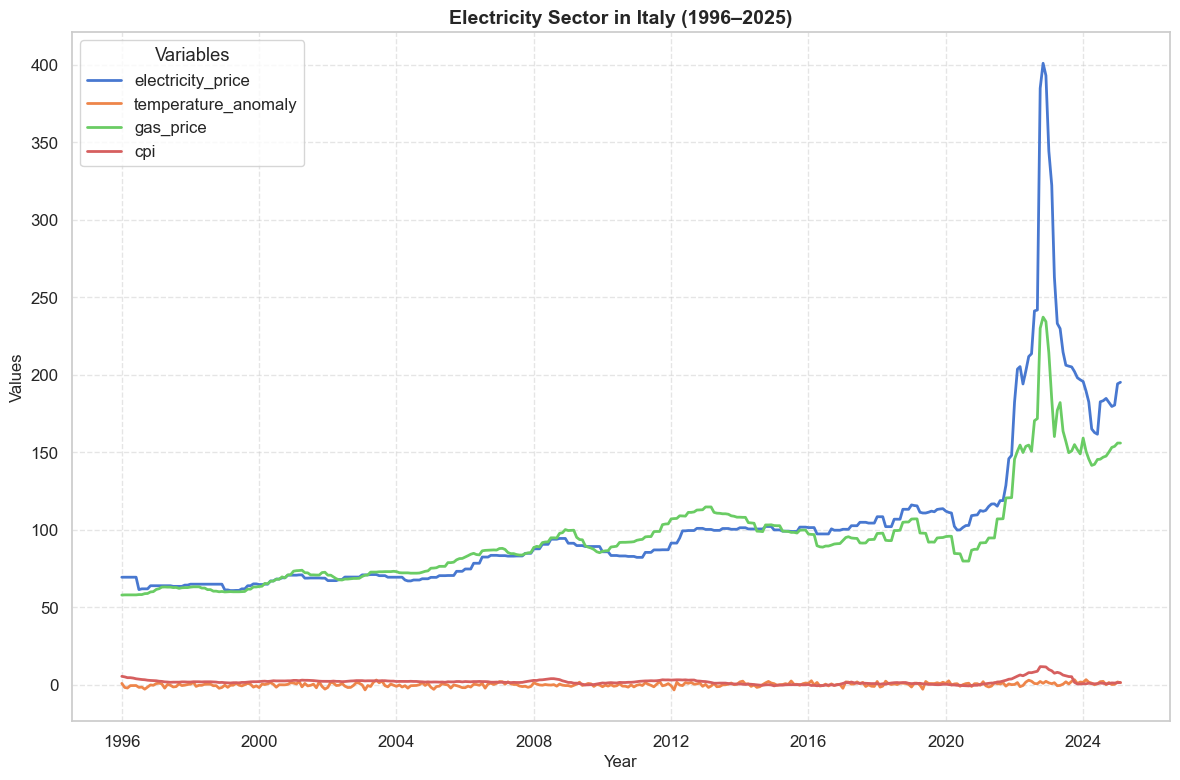

In [156]:
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.figure(figsize=(12,8))

for column in prices:
    plt.plot(prices.index, prices[column], label=column, linewidth=2)

plt.title('Electricity Sector in Italy (1996–2025)', fontsize=14, weight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.legend(loc='upper left', title="Variables")

plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [157]:
monthly_data_normalized = prices.copy()
avgs = monthly_data_normalized.mean()
devs = monthly_data_normalized.std()
for col in monthly_data_normalized.columns:
    monthly_data_normalized[col] = (monthly_data_normalized[col] - avgs.loc[col]) / devs.loc[col]

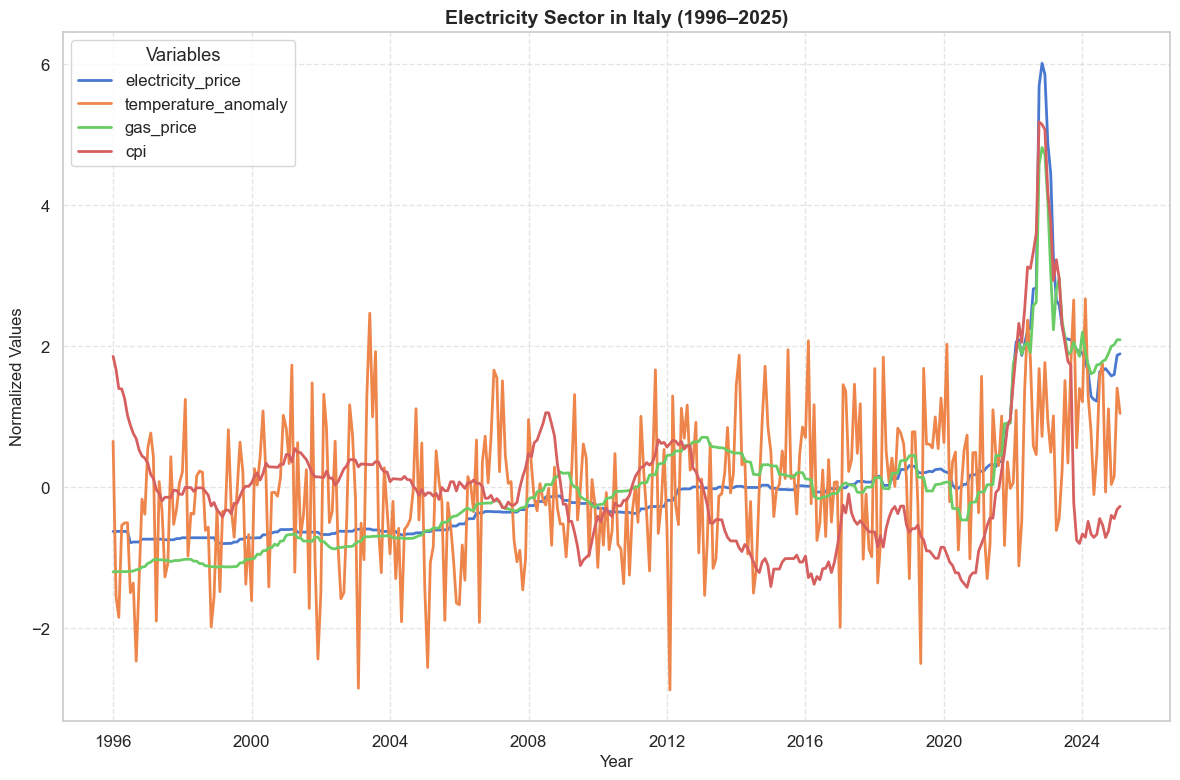

In [158]:
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.figure(figsize=(12,8))

for column in monthly_data_normalized:
    plt.plot(monthly_data_normalized.index, monthly_data_normalized[column], label=column, linewidth=2)

plt.title('Electricity Sector in Italy (1996–2025)', fontsize=14, weight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Normalized Values', fontsize=12)
plt.legend(loc='upper left', title="Variables")

plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# var model annual data

## stationarity test

<Axes: xlabel='year'>

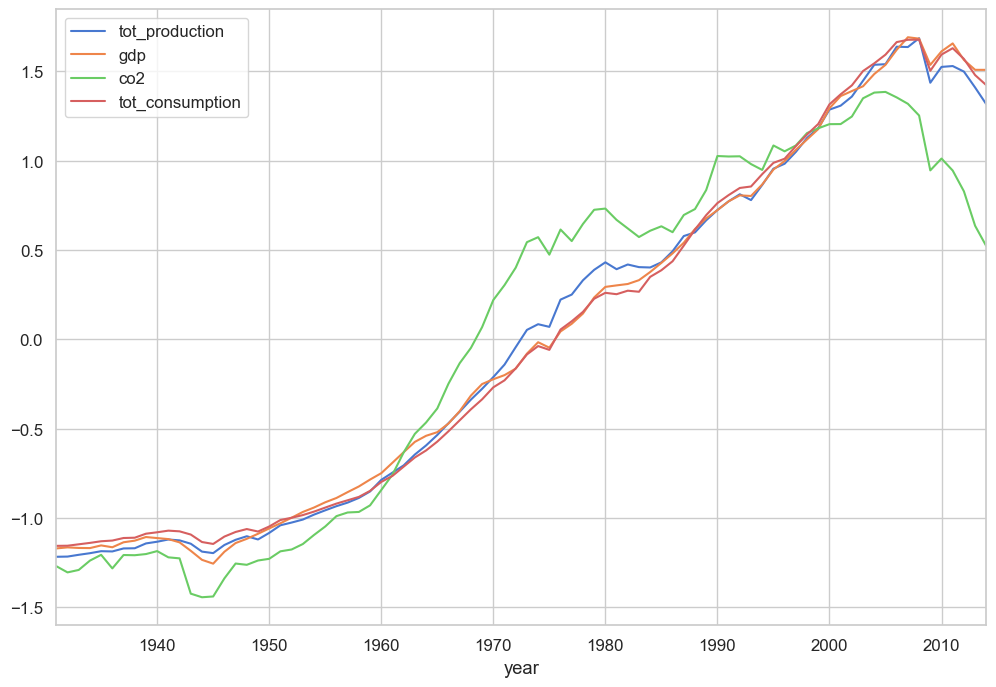

In [159]:
var_data.plot(figsize=(12,8))

In [160]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())         
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
    return out

In [161]:
adf_results = {}
for var in var_data.columns:
    print('-----------------------------------------------------------------')
    adf_results[var] = adf_test(var_data[var],title=var)

-----------------------------------------------------------------
Augmented Dickey-Fuller Test: tot_production
ADF test statistic      -1.351129
p-value                  0.605469
# lags used              4.000000
# observations          79.000000
critical value (1%)     -3.515977
critical value (5%)     -2.898886
critical value (10%)    -2.586694
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
-----------------------------------------------------------------
Augmented Dickey-Fuller Test: gdp
ADF test statistic      -0.318433
p-value                  0.922853
# lags used              3.000000
# observations          80.000000
critical value (1%)     -3.514869
critical value (5%)     -2.898409
critical value (10%)    -2.586439
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
-----------------------------------------------------------------
Augment

In [162]:
for var,result in adf_results.items():
    print(f"{var}: p-value = {result['p-value']}")

tot_production: p-value = 0.6054685093948774
gdp: p-value = 0.9228528021554896
co2: p-value = 0.6047578177242096
tot_consumption: p-value = 0.46866581897021947


In [163]:
def adf_test_(series):
    result = adfuller(series.dropna(), autolag='AIC')
    return result[1]  # return only the p-value

stationary_data = var_data.copy()
diff_count = {col: 0 for col in stationary_data.columns}

# Loop through each column
for col in stationary_data.columns:
    pval = adf_test_(stationary_data[col])
    
    # Keep differencing until the series becomes stationary
    while pval > 0.05:
        stationary_data[col] = stationary_data[col].diff()
        diff_count[col] += 1
        pval = adf_test_(stationary_data[col])

        print(f"{col}: differenced {diff_count[col]} time(s), p-value = {pval:.4f}")

stationary_data = stationary_data.dropna()

print("\nNumber of differences applied per variable:")
print(pd.Series(diff_count))

print("\nStationary DataFrame ready for VAR model:")
print(stationary_data.head())

tot_production: differenced 1 time(s), p-value = 0.5047
tot_production: differenced 2 time(s), p-value = 0.0000
gdp: differenced 1 time(s), p-value = 0.0383
co2: differenced 1 time(s), p-value = 0.0068
tot_consumption: differenced 1 time(s), p-value = 0.5168
tot_consumption: differenced 2 time(s), p-value = 0.0000

Number of differences applied per variable:
tot_production     2
gdp                1
co2                1
tot_consumption    2
dtype: int64

Stationary DataFrame ready for VAR model:
            tot_production       gdp       co2  tot_consumption
year                                                           
1933-01-01        0.008838 -0.003220  0.013688         0.007185
1934-01-01       -0.001034 -0.000713  0.052198        -0.000064
1935-01-01        0.002351  0.014918  0.032472         0.001304
1936-01-01       -0.012712 -0.010294 -0.076058        -0.005371
1937-01-01        0.018184  0.027898  0.074910         0.010504


In [164]:
stationary_data.head()

tot_production       gdp       co2  tot_consumption
year                                                           
1933-01-01        0.008838 -0.003220  0.013688         0.007185
1934-01-01       -0.001034 -0.000713  0.052198        -0.000064
1935-01-01        0.002351  0.014918  0.032472         0.001304
1936-01-01       -0.012712 -0.010294 -0.076058        -0.005371
1937-01-01        0.018184  0.027898  0.074910         0.010504

In [165]:
adf_results = {}
for var in stationary_data.columns:
    print('-----------------------------------------------------------------')
    adf_results[var] = adf_test(stationary_data[var],title=var)

-----------------------------------------------------------------
Augmented Dickey-Fuller Test: tot_production
ADF test statistic     -9.694456e+00
p-value                 1.113944e-16
# lags used             2.000000e+00
# observations          7.900000e+01
critical value (1%)    -3.515977e+00
critical value (5%)    -2.898886e+00
critical value (10%)   -2.586694e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
-----------------------------------------------------------------
Augmented Dickey-Fuller Test: gdp
ADF test statistic      -2.926364
p-value                  0.042367
# lags used              2.000000
# observations          79.000000
critical value (1%)     -3.515977
critical value (5%)     -2.898886
critical value (10%)    -2.586694
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
-----------------------------------------------------------------
Augm

## var model

In [166]:
for i in [1,2,3,4,5,6,7]:
    model = VAR(stationary_data)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  -26.903392001525805
BIC:  -26.312169988026437

Order = 2
AIC:  -27.162511188812264
BIC:  -26.090599203209017

Order = 3
AIC:  -27.567667874887334
BIC:  -26.008031313769802

Order = 4
AIC:  -27.399535678747057
BIC:  -25.34496900932536

Order = 5
AIC:  -27.429565749720165
BIC:  -24.872687107697967

Order = 6
AIC:  -27.347657772008922
BIC:  -24.280903376895328

Order = 7
AIC:  -27.37532200917486
BIC:  -23.790940393572033



In [167]:
results = model.fit(2)

In [168]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 04, May, 2025
Time:                     11:46:23
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -26.0906
Nobs:                     80.0000    HQIC:                  -26.7328
Log likelihood:           668.440    FPE:                1.60374e-12
AIC:                     -27.1625    Det(Omega_mle):     1.04697e-12
--------------------------------------------------------------------
Results for equation tot_production
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.012466         0.008898            1.401           0.161
L1.tot_production         -1.290451         0.227074           -5.683           0.000
L1.gdp                    -0.08

# varmax model monthly data

## stationarity test

In [169]:
adf_results = {}
for var in monthly_data_normalized.columns:
    print('-----------------------------------------------------------------')
    adf_results[var] = adf_test(monthly_data_normalized[var],title=var)

-----------------------------------------------------------------
Augmented Dickey-Fuller Test: electricity_price
ADF test statistic       -1.911607
p-value                   0.326621
# lags used               9.000000
# observations          340.000000
critical value (1%)      -3.449730
critical value (5%)      -2.870079
critical value (10%)     -2.571319
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
-----------------------------------------------------------------
Augmented Dickey-Fuller Test: temperature_anomaly
ADF test statistic     -8.023061e+00
p-value                 2.051624e-12
# lags used             2.000000e+00
# observations          3.470000e+02
critical value (1%)    -3.449337e+00
critical value (5%)    -2.869906e+00
critical value (10%)   -2.571227e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
-----------------------------------

In [170]:
auto_arima(monthly_data_normalized['electricity_price'],maxiter=1000)

ARIMA(maxiter=1000, order=(3, 1, 2), scoring_args={}, suppress_warnings=True)

In [171]:
auto_arima(monthly_data_normalized['gas_price'],maxiter=1000)

ARIMA(maxiter=1000, order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [172]:
endog_vars = ['electricity_price','gas_price']
exog_vars = ['temperature_anomaly','cpi']

In [173]:
def adf_test_(series):
    return adfuller(series.dropna(), autolag='AIC')[1]  

def make_all_stationary(data, endog_vars, exog_vars):
    data = data.copy()
    all_vars = endog_vars + exog_vars
    diff_count = {col: 0 for col in all_vars}
    
    for col in all_vars:
        pval = adf_test_(data[col])
        while pval > 0.05:
            data[col] = data[col].diff()
            diff_count[col] += 1
            pval = adf_test_(data[col])
            print(f"{col}: differenced {diff_count[col]} time(s), p-value = {pval:.4f}")
    
    data = data.dropna()

    # Split into endogenous and exogenous
    endog = data[endog_vars]
    exog = data[exog_vars]

    print("\nNumber of differences applied per variable:")
    print(pd.Series(diff_count))
    
    print("\nStationary DataFrame ready for VARMAX model:")
    print(data.head())

    return endog, exog, diff_count

In [174]:
endog, exog, diff_count = make_all_stationary(monthly_data_normalized,endog_vars,exog_vars)

electricity_price: differenced 1 time(s), p-value = 0.0000
gas_price: differenced 1 time(s), p-value = 0.0000

Number of differences applied per variable:
electricity_price      1
gas_price              1
temperature_anomaly    0
cpi                    0
dtype: int64

Stationary DataFrame ready for VARMAX model:
                  electricity_price  temperature_anomaly  gas_price       cpi
observation_date                                                             
1996-02-01                      0.0            -1.551221    0.00336  1.670550
1996-03-01                      0.0            -1.847361    0.00000  1.399165
1996-04-01                      0.0            -0.541939    0.00000  1.394534
1996-05-01                      0.0            -0.506993    0.00000  1.259119
1996-06-01                      0.0            -0.505565    0.00000  1.019321


In [176]:
df_transformed = endog.merge(exog,left_index=True,right_index=True,how='left')

In [177]:
df_transformed

electricity_price  gas_price  temperature_anomaly       cpi
observation_date                                                             
1996-02-01                 0.000000   0.003360            -1.551221  1.670550
1996-03-01                 0.000000   0.000000            -1.847361  1.399165
1996-04-01                 0.000000   0.000000            -0.541939  1.394534
1996-05-01                 0.000000   0.000000            -0.506993  1.259119
1996-06-01                 0.000000   0.000000            -0.505565  1.019321
...                             ...        ...                  ...       ...
2024-10-01                -0.050111   0.087368             1.111111 -0.625060
2024-11-01                -0.054120   0.100809             0.037628 -0.400088
2024-12-01                 0.018040   0.023522             0.153154 -0.445709
2025-01-01                 0.274608   0.070567             1.406692 -0.315080
2025-02-01                 0.020044   0.000000             1.046635 -0.271497

[349 rows x 4 columns]

## train and test split

In [178]:
nobs=12
train, test = df_transformed[0:-nobs], df_transformed[-nobs:]

In [179]:
print(train.shape)
print(test.shape)

(337, 4)
(12, 4)


In [180]:
train

electricity_price  gas_price  temperature_anomaly       cpi
observation_date                                                             
1996-02-01                 0.000000   0.003360            -1.551221  1.670550
1996-03-01                 0.000000   0.000000            -1.847361  1.399165
1996-04-01                 0.000000   0.000000            -0.541939  1.394534
1996-05-01                 0.000000   0.000000            -0.506993  1.259119
1996-06-01                 0.000000   0.000000            -0.505565  1.019321
...                             ...        ...                  ...       ...
2023-10-01                -0.060133   0.137773             2.655858 -0.211516
2023-11-01                -0.080177  -0.110890             0.558957 -0.753730
2023-12-01                -0.026058  -0.090728             1.400690 -0.799325
2024-01-01                -0.022049   0.342752             1.214052 -0.665624
2024-02-01                -0.124275  -0.285627             2.672105 -0.710953

[337 rows x 4 columns]

In [181]:
test

electricity_price  gas_price  temperature_anomaly       cpi
observation_date                                                             
2024-03-01                -0.140311  -0.168016             1.301582 -0.485427
2024-04-01                -0.348772  -0.137773             0.780848 -0.666373
2024-05-01                -0.046102   0.023522            -0.105282 -0.712293
2024-06-01                -0.022049   0.104170             0.479104 -0.667863
2024-07-01                 0.418927   0.006721             1.587051 -0.445709
2024-08-01                 0.014031   0.043684             1.746568 -0.536494
2024-09-01                 0.030067   0.023522            -0.068757 -0.714288
2024-10-01                -0.050111   0.087368             1.111111 -0.625060
2024-11-01                -0.054120   0.100809             0.037628 -0.400088
2024-12-01                 0.018040   0.023522             0.153154 -0.445709
2025-01-01                 0.274608   0.070567             1.406692 -0.315080
2025-02-01                 0.020044   0.000000             1.046635 -0.271497

## best model

In [182]:
from statsmodels.tsa.statespace.varmax import VARMAX
import numpy as np

def select_varmax_order(endog, exog, max_p=5, max_q=3, ic='aic'):
    best_aic = np.inf
    best_order = None
    best_model = None

    for p in range(1, max_p + 1):
        for q in range(0, max_q + 1):
            try:
                model = VARMAX(endog=endog, exog=exog, order=(p, q))
                results = model.fit(disp=False)
                current_ic = getattr(results, ic)

                print(f"Trying order (p={p}, q={q}) | {ic.upper()} = {current_ic:.4f}")

                if current_ic < best_aic:
                    best_aic = current_ic
                    best_order = (p, q)
                    best_model = results

            except Exception as e:
                print(f"Skipping (p={p}, q={q}) due to error: {e}")
                continue

    print(f"\nBest order selected: (p={best_order[0]}, q={best_order[1]}) with {ic.upper()} = {best_aic:.4f}")
    return best_model, best_order

In [183]:
best_model, best_order = select_varmax_order(train[endog_vars],train[exog_vars],max_p=5,max_q=3,ic='aic')
print(best_model.summary())

Trying order (p=1, q=0) | AIC = -769.0637
Trying order (p=1, q=1) | AIC = -803.1421
Trying order (p=1, q=2) | AIC = -849.7031
Trying order (p=1, q=3) | AIC = -856.2307
Trying order (p=2, q=0) | AIC = -826.9422
Trying order (p=2, q=1) | AIC = -841.9646
Trying order (p=2, q=2) | AIC = -937.0181
Trying order (p=2, q=3) | AIC = -952.2422
Trying order (p=3, q=0) | AIC = -841.0907
Trying order (p=3, q=1) | AIC = -907.0727
Trying order (p=3, q=2) | AIC = -949.3261
Trying order (p=3, q=3) | AIC = -1009.6462
Trying order (p=4, q=0) | AIC = -909.7697
Trying order (p=4, q=1) | AIC = -917.5978
Trying order (p=4, q=2) | AIC = -970.2571
Trying order (p=4, q=3) | AIC = -1045.1780
Trying order (p=5, q=0) | AIC = -936.4276
Trying order (p=5, q=1) | AIC = -955.3404
Trying order (p=5, q=2) | AIC = -1018.7196
Trying order (p=5, q=3) | AIC = -1032.6925

Best order selected: (p=4, q=3) with AIC = -1045.1780
                                   Statespace Model Results                                   
Dep. V

In [184]:
best_model, best_order = select_varmax_order(train[endog_vars],train[exog_vars],max_p=5,max_q=3,ic='bic')
print(best_model.summary())

Trying order (p=1, q=0) | BIC = -719.4027
Trying order (p=1, q=1) | BIC = -738.2007
Trying order (p=1, q=2) | BIC = -769.4813
Trying order (p=1, q=3) | BIC = -760.7286
Trying order (p=2, q=0) | BIC = -762.0008
Trying order (p=2, q=1) | BIC = -761.7429
Trying order (p=2, q=2) | BIC = -841.5160
Trying order (p=2, q=3) | BIC = -841.4598
Trying order (p=3, q=0) | BIC = -760.8690
Trying order (p=3, q=1) | BIC = -811.5706
Trying order (p=3, q=2) | BIC = -838.5437
Trying order (p=3, q=3) | BIC = -883.5835
Trying order (p=4, q=0) | BIC = -814.2676
Trying order (p=4, q=1) | BIC = -806.8154
Trying order (p=4, q=2) | BIC = -844.1944
Trying order (p=4, q=3) | BIC = -903.8350
Trying order (p=5, q=0) | BIC = -825.6452
Trying order (p=5, q=1) | BIC = -829.2777
Trying order (p=5, q=2) | BIC = -877.3766
Trying order (p=5, q=3) | BIC = -876.0691

Best order selected: (p=4, q=3) with BIC = -903.8350
                                   Statespace Model Results                                   
Dep. Variab

## fit varmax(4,3)

In [197]:
model = VARMAX(endog=train[endog_vars], 
               exog=train[exog_vars],
               order=(4,3))  
results = model.fit(disp=False)
print(results.summary())

                                   Statespace Model Results                                   
Dep. Variable:     ['electricity_price', 'gas_price']   No. Observations:                  337
Model:                                    VARMAX(4,3)   Log Likelihood                 559.589
                                          + intercept   AIC                          -1045.178
Date:                                Sun, 04 May 2025   BIC                           -903.835
Time:                                        12:20:40   HQIC                          -988.841
Sample:                                    02-01-1996                                         
                                         - 02-01-2024                                         
Covariance Type:                                  opg                                         
Ljung-Box (L1) (Q):             0.67, 0.37   Jarque-Bera (JB):   229614.16, 1053.73
Prob(Q):                        0.41, 0.54   Prob(JB):       

## predict the next 12 values

In [186]:
test

electricity_price  gas_price  temperature_anomaly       cpi
observation_date                                                             
2024-03-01                -0.140311  -0.168016             1.301582 -0.485427
2024-04-01                -0.348772  -0.137773             0.780848 -0.666373
2024-05-01                -0.046102   0.023522            -0.105282 -0.712293
2024-06-01                -0.022049   0.104170             0.479104 -0.667863
2024-07-01                 0.418927   0.006721             1.587051 -0.445709
2024-08-01                 0.014031   0.043684             1.746568 -0.536494
2024-09-01                 0.030067   0.023522            -0.068757 -0.714288
2024-10-01                -0.050111   0.087368             1.111111 -0.625060
2024-11-01                -0.054120   0.100809             0.037628 -0.400088
2024-12-01                 0.018040   0.023522             0.153154 -0.445709
2025-01-01                 0.274608   0.070567             1.406692 -0.315080
2025-02-01                 0.020044   0.000000             1.046635 -0.271497

In [187]:
forecast_steps = 12
exog_forecast = test[exog_vars]

df_forecast = results.forecast(steps=forecast_steps, exog=exog_forecast)
df_forecast.index = monthly_data_normalized.index[-nobs:]  
print(df_forecast)

                  electricity_price  gas_price
observation_date                              
2024-03-01                -0.071293  -0.071309
2024-04-01                -0.097194   0.061888
2024-05-01                 0.111578  -0.082588
2024-06-01                -0.046225  -0.031896
2024-07-01                -0.009718   0.090004
2024-08-01                 0.034266  -0.007023
2024-09-01                -0.037222  -0.088379
2024-10-01                -0.042589  -0.022473
2024-11-01                -0.020827   0.011468
2024-12-01                -0.007060   0.002944
2025-01-01                -0.001253   0.003632
2025-02-01                 0.007936   0.000015


In [188]:
for var in endog_vars:
    if diff_count[var] > 0:
        last_val = monthly_data_normalized[var].iloc[-nobs - diff_count[var]]
        df_forecast[f'{var}_forecast'] = last_val + df_forecast[var].cumsum()
    else:
        df_forecast[f'{var}_forecast'] = df_forecast[var]

In [189]:
df_forecast

electricity_price  gas_price  electricity_price_forecast  \
observation_date                                                             
2024-03-01                -0.071293  -0.071309                    1.706408   
2024-04-01                -0.097194   0.061888                    1.609214   
2024-05-01                 0.111578  -0.082588                    1.720792   
2024-06-01                -0.046225  -0.031896                    1.674567   
2024-07-01                -0.009718   0.090004                    1.664850   
2024-08-01                 0.034266  -0.007023                    1.699116   
2024-09-01                -0.037222  -0.088379                    1.661894   
2024-10-01                -0.042589  -0.022473                    1.619305   
2024-11-01                -0.020827   0.011468                    1.598478   
2024-12-01                -0.007060   0.002944                    1.591419   
2025-01-01                -0.001253   0.003632                    1.590166   
2025-02-01                 0.007936   0.000015                    1.598102   

                  gas_price_forecast  
observation_date                      
2024-03-01                  1.842149  
2024-04-01                  1.904037  
2024-05-01                  1.821449  
2024-06-01                  1.789553  
2024-07-01                  1.879557  
2024-08-01                  1.872534  
2024-09-01                  1.784156  
2024-10-01                  1.761683  
2024-11-01                  1.773151  
2024-12-01                  1.776095  
2025-01-01                  1.779726  
2025-02-01                  1.779741

In [190]:
df_forecast[['electricity_price_forecast','gas_price_forecast']]

electricity_price_forecast  gas_price_forecast
observation_date                                                
2024-03-01                          1.706408            1.842149
2024-04-01                          1.609214            1.904037
2024-05-01                          1.720792            1.821449
2024-06-01                          1.674567            1.789553
2024-07-01                          1.664850            1.879557
2024-08-01                          1.699116            1.872534
2024-09-01                          1.661894            1.784156
2024-10-01                          1.619305            1.761683
2024-11-01                          1.598478            1.773151
2024-12-01                          1.591419            1.776095
2025-01-01                          1.590166            1.779726
2025-02-01                          1.598102            1.779741

In [191]:
pd.concat([monthly_data_normalized.iloc[-nobs:], df_forecast[['electricity_price_forecast', 
                                              'gas_price_forecast']]], axis=1)

electricity_price  temperature_anomaly  gas_price       cpi  \
observation_date                                                                
2024-03-01                 1.637390             1.301582   1.745442 -0.485427   
2024-04-01                 1.288618             0.780848   1.607669 -0.666373   
2024-05-01                 1.242516            -0.105282   1.631192 -0.712293   
2024-06-01                 1.220467             0.479104   1.735361 -0.667863   
2024-07-01                 1.639394             1.587051   1.742082 -0.445709   
2024-08-01                 1.653425             1.746568   1.785766 -0.536494   
2024-09-01                 1.683492            -0.068757   1.809288 -0.714288   
2024-10-01                 1.633381             1.111111   1.896656 -0.625060   
2024-11-01                 1.579261             0.037628   1.997466 -0.400088   
2024-12-01                 1.597301             0.153154   2.020988 -0.445709   
2025-01-01                 1.871909             1.406692   2.091554 -0.315080   
2025-02-01                 1.891953             1.046635   2.091554 -0.271497   

                  electricity_price_forecast  gas_price_forecast  
observation_date                                                  
2024-03-01                          1.706408            1.842149  
2024-04-01                          1.609214            1.904037  
2024-05-01                          1.720792            1.821449  
2024-06-01                          1.674567            1.789553  
2024-07-01                          1.664850            1.879557  
2024-08-01                          1.699116            1.872534  
2024-09-01                          1.661894            1.784156  
2024-10-01                          1.619305            1.761683  
2024-11-01                          1.598478            1.773151  
2024-12-01                          1.591419            1.776095  
2025-01-01                          1.590166            1.779726  
2025-02-01                          1.598102            1.779741

## plot the result

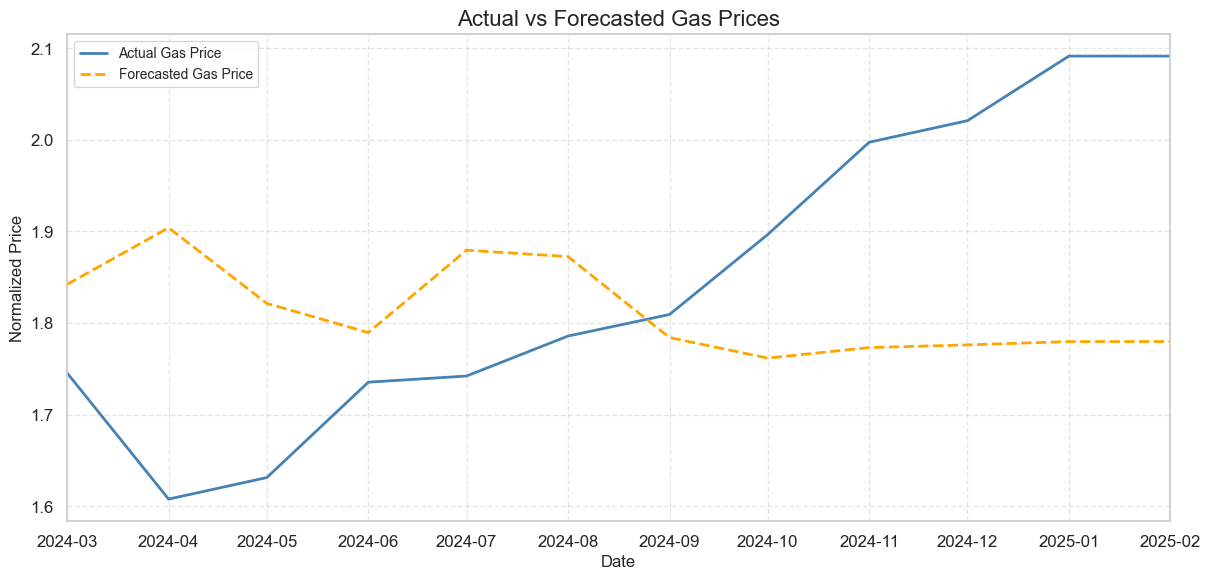

In [192]:
plt.figure(figsize=(12, 6))
plt.plot(
    monthly_data_normalized['gas_price'][-nobs:], 
    label='Actual Gas Price', 
    color='steelblue', 
    linewidth=2
)
plt.plot(
    df_forecast['gas_price_forecast'], 
    label='Forecasted Gas Price', 
    color='orange', 
    linestyle='--', 
    linewidth=2
)

plt.title('Actual vs Forecasted Gas Prices', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.autoscale(axis='x', tight=True)
plt.show()

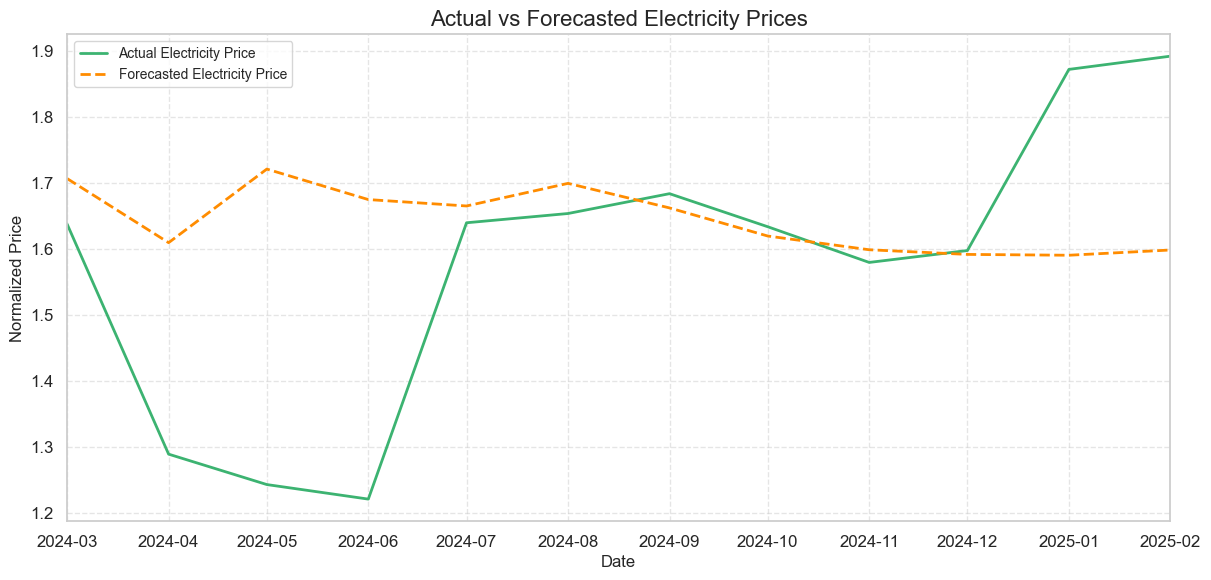

In [193]:
plt.figure(figsize=(12, 6))
plt.plot(
    monthly_data_normalized['electricity_price'][-nobs:], 
    label='Actual Electricity Price', 
    color='mediumseagreen', 
    linewidth=2
)
plt.plot(
    df_forecast['electricity_price_forecast'], 
    label='Forecasted Electricity Price', 
    color='darkorange', 
    linestyle='--', 
    linewidth=2
)

plt.title('Actual vs Forecasted Electricity Prices', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.autoscale(axis='x', tight=True)
plt.show()

In [194]:
RMSE1 = rmse(monthly_data_normalized['electricity_price'][-nobs:], df_forecast['electricity_price_forecast'])
print(f'Electricity Price VARMAX(3) RMSE: {RMSE1:.3f}')

Electricity Price VARMAX(3) RMSE: 0.244


In [195]:
RMSE2 = rmse(monthly_data_normalized['gas_price'][-nobs:], df_forecast['gas_price_forecast'])
print(f'Gas Price VARMAX(3) RMSE: {RMSE2:.3f}')

Gas Price VARMAX(3) RMSE: 0.201
